# **Multiple Models ML + ResNet Threshold Cross Validation**

## *1. Dataset Loading and Preprocessing*

### **1.1. Importing Required Libraries**


This section imports all necessary Python libraries:

- OS, shutil, and pathlib: For file system operations.

- NumPy and Pandas: Handling numerical data and DataFrames.

- Matplotlib and Seaborn: Data visualization.

- Pickle: Storing and loading serialized objects.

- PIL (Pillow): Image processing.

- tqdm: Progress tracking for loops.

- Torch and Torchvision: Deep learning and dataset handling.

- Scikit-learn (StandardScaler): Normalizing dataset features.


#### Key Notes:

 - Using pathlib for path handling improves cross-platform compatibility.

- Torch and Torchvision are used to load image datasets and prepare for deep learning tasks.

- Using Pickle enables storing large DataFrames efficiently for future use.

In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

import pickle

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

c:\Users\majid\anaconda3\envs\ENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **1.2. Download and extract the data**

#### **Dataset Directory and Checkpoints Setup**

- Setting up dataset paths dynamically using os.path.abspath("__file__") to locate the dataset.

- Normalizing paths for compatibility across Windows and Linux.

- Checkpoint directory creation ensures data persistence for large datasets.

#### Key Notes:

- Using os.makedirs(..., exist_ok=True) prevents errors if the directory already exists.

- Relative path handling makes the script more portable across environments.

- Checkpoints help reduce load time by storing preprocessed data.

In [2]:
# Load the dataset in chunks to avoid MemoryError
dataset_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), "..\..\..\Dataset")
dataset_dir = os.path.normpath(dataset_dir)
file_path = os.path.join(dataset_dir, 'mvtec_meta_features_dataset.csv')


### **1.3. Loading Dataset with Chunk Processing**

#### Explanation:

- Checks if a preprocessed dataset exists to load faster.

- Uses chunk processing (chunksize=1000) to prevent MemoryErrors on large CSV files.

- Saves the final DataFrame to a pickle file for efficiency.

#### Key Notes:

- Chunk processing is essential for handling large datasets in memory-constrained environments.

- Pickle is faster than CSV for loading structured data.

- Using ignore_index=True ensures the DataFrame is properly indexed after concatenation.

### **1.4. Display Dataset Preview**

This prints a preview of the dataset to ensure it loaded correctly.

In [3]:
# Define the checkpoint path
checkpoint_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'Checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'features_df_checkpoint.pkl')

# Check if the checkpoint file exists
if os.path.exists(checkpoint_path):
	# Load the DataFrame from the checkpoint file
	with open(checkpoint_path, 'rb') as f:
		features_df = pickle.load(f)
else:
	# Load the dataset in chunks to avoid MemoryError
	chunk_size = 1000  # Adjust the chunk size based on your memory capacity
	chunks = []
	for chunk in pd.read_csv(file_path, chunksize=chunk_size):
		chunks.append(chunk)
	features_df = pd.concat(chunks, ignore_index=True)

	# Save the DataFrame to a checkpoint file
	with open(checkpoint_path, 'wb') as f:
		pickle.dump(features_df, f)

# Display the first few rows of the DataFrame
features_df.head()

,category,subclass,set_type,anomaly_status,anomaly_type,width,height,aspect_ratio,num_pixels_b,num_pixels_g,...,pixel_150519,pixel_150520,pixel_150521,pixel_150522,pixel_150523,pixel_150524,pixel_150525,pixel_150526,pixel_150527,pixel_150528
0,bottle,Consumer Products,train,normal,none,900,900,1.0,6999311,6773371,...,255,255,255,255,255,255,255,255,255,255
1,bottle,Consumer Products,train,normal,none,900,900,1.0,7067411,6860049,...,255,255,255,255,255,255,255,255,255,255
2,bottle,Consumer Products,train,normal,none,900,900,1.0,6960857,6767973,...,255,255,255,255,255,255,255,255,255,255
3,bottle,Consumer Products,train,normal,none,900,900,1.0,6941894,6749162,...,255,255,255,255,255,255,255,255,255,255
4,bottle,Consumer Products,train,normal,none,900,900,1.0,7080991,6879424,...,255,255,255,255,255,255,255,255,255,255


- Dataset Example: The table shows meta-data for a few images. Each row represents an image, and columns represent various image features like:

- Category: The object category the image belongs to.
- Anomaly Status: Whether the image is normal or contains an anomaly.
- Pixel Data: Columns like num_pixels_b, num_pixels_g, and num_pixels_r represent the pixel counts of each color channel. These features can be used for distinguishing different object types or identifying anomalies.

### **1.5. Category Extraction and Initialization**

- Extracts all unique categories from the dataset.

- Sorts them alphabetically for consistency.

- Sets bounds for category filtering.

#### Key Notes:

- Sorting ensures order consistency when iterating through categories.

- Setting min/max boundaries can help in controlled dataset sampling.

- Avoiding hardcoded categories improves adaptability to new datasets.



In [4]:
# create a list of the categories
categories = np.sort(features_df['category'].unique())
min_categories = 0
max_categories = 15


### **1.6. Image Path Extraction**

Extracts all unique categories from the dataset.

- Defines a function to extract image paths from different dataset folders.

- Uses os.walk() to recursively find all images inside the specified directories.

- Supports multiple image formats (PNG, JPG, BMP, etc.).

- Sorts them alphabetically for consistency.

- Sets bounds for category filtering.

#### Notes: 

- **Using **.lower().endswith() makes the code case-insensitive.

- Recursive os.walk() ensures all images in subdirectories are found.

- Keeping functions modular improves reusability.

- Sorting ensures order consistency when iterating through categories.

- Setting min/max boundaries can help in controlled dataset sampling.

- Avoiding hardcoded categories improves adaptability to new datasets.



### **1.7. Organizing Image Paths**

### Explanation:

- Iterates over all categories to extract image paths.

- Stores image paths in dictionaries for easy access and processing.

### Key Notes:

- Dictionaries allow fast lookup of image paths by category.

- Avoids redundant file system calls by storing paths once.

- Ensures train/test/ground-truth datasets are well-structured.



In [7]:
# Function to get all image and ground_truth paths for all categories
def load_image_paths_from_category(category):
    train_path = os.path.join(dataset_dir, category, 'train')
    test_path = os.path.join(dataset_dir, category, 'test')
    gt_path = os.path.join(dataset_dir, category, 'ground_truth')
    
    def get_image_paths(root_path):
        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
        image_paths = []
        for dirpath, _, filenames in os.walk(root_path):
            for filename in filenames:
                if filename.lower().endswith(image_extensions):
                    image_paths.append(os.path.join(dirpath, filename))
        return image_paths
    
    def get_ground_truth_paths(root_path):
        ground_truth_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
        ground_truth_paths = []
        for dirpath, _, filenames in os.walk(root_path):
            for filename in filenames:
                if filename.lower().endswith(ground_truth_extensions):
                    ground_truth_paths.append(os.path.join(dirpath, filename))
        return ground_truth_paths
    
    # Get image and ground_truth paths
    train_image_paths = get_image_paths(train_path)
    test_image_paths = get_image_paths(test_path)
    gt_image_paths = get_ground_truth_paths(gt_path)
   
    return train_image_paths, test_image_paths, gt_image_paths

# Initialize dictionaries to store images
train_image_paths_dict = {}
test_image_paths_dict = {}
gt_image_paths_dict = {}

for category in categories:
    train_image_paths, test_image_paths, gt_image_paths = load_image_paths_from_category(category)
    train_image_paths_dict[category] = train_image_paths
    test_image_paths_dict[category] = test_image_paths
    gt_image_paths_dict[category] = gt_image_paths


### Conclusion of first part
This approach ensures memory efficiency, reduces dataset load time, and structures image paths systematically for further deep learning tasks. This section sets up the dataset efficiently by:

- Handling large CSV files with chunk processing.

- Creating checkpoints to avoid redundant loading.

- Extracting image paths dynamically for flexible processing.

## *2. Load a Pretrained Resnet Model*

- ResNet50 is a deep convolutional neural network used for feature extraction.

- The last layer (fully connected) is removed to retain feature embeddings.

- The model is set to evaluation mode and moved to the GPU.

- Gradient updates are disabled to save memory and improve efficiency.

#### Advantages:
1. ResNet50 is well-suited for feature extraction due to its depth and pretraining on ImageNet.

2. Freezing parameters prevents unintended updates when used as a feature extractor.

3. Removing the last layer outputs embeddings instead of classification scores.

In [8]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

model = torch.nn.Sequential(*list(resnet_model.children())[:-1]).cuda()
model.eval()

for param in model.parameters():
    param.requires_grad = False

del resnet_model

## *3. Prepare data transformations*

- Uses default ResNet50 transformations (normalization, resizing, etc.)

- Ensures input images match what ResNet50 expects.

1. Transforms standardize images for better feature extraction.

2. Resizing maintains consistency across input images.

3. Pretrained models require specific normalization for optimal performance.

In [9]:
transform = ResNet50_Weights.DEFAULT.transforms()

## *4. Creating Memory Bank for Training Data (features-embeddings)*

- Extracts feature embeddings for each training image using the ResNet model.

- Stores the extracted features in a memory bank.

- Uses torch.no_grad() to disable gradient computation for efficiency.

1. Feature embeddings are saved to avoid recomputation when reloading data.

2. TQDM progress bars provide visualization of the extraction process.

3. CUDA optimizes performance by using GPU for computations.

In [10]:
checkpoint_file = os.path.join(checkpoint_dir, 'memory_bank_train_checkpoint.pkl')

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        train_resnet_features_dict = pickle.load(f)
else:
    train_resnet_features_dict = {}
    

    for category, paths in train_image_paths_dict.items():
        train_features = []
        for pth in tqdm(paths, leave=False):
            with torch.no_grad():
                data = transform(Image.open(pth).convert('RGB')).cuda().unsqueeze(0)
                features = model(data)
                train_features.append(features.squeeze().cpu().detach())
        train_resnet_features_dict[category] = torch.stack(train_features).cuda()
    
    with open(checkpoint_file, 'wb') as f:
        pickle.dump(train_resnet_features_dict, f)


## *5. Creating Memory Bank for Test Data*

- Similar to training data but processes test images.

- Assigns ground truth labels (0 for normal, 1 for anomaly).

1. Embeddings reduce storage needs compared to raw images.

2. Using Path(pth).parts[-2] extracts category labels dynamically.

3. Storing ground truth helps in evaluation and classification.

In [12]:
checkpoint_file = os.path.join(checkpoint_dir, 'memory_bank_test_checkpoint.pkl')

# Initialize y_true_test_dict
y_true_test_dict = {}

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        test_resnet_features_dict = pickle.load(f)
else:
    test_resnet_features_dict = {}

    for category, paths in test_image_paths_dict.items():
        test_features = []
        y_true_test = []
        for pth in tqdm(paths, leave=False):
            with torch.no_grad():
                data = transform(Image.open(pth).convert('RGB')).cuda().unsqueeze(0)
                features = model(data)
                test_features.append(features.squeeze().cpu().detach())

            class_label = Path(pth).parts[-2]
            y_true_test.append(0 if class_label == 'good' else 1)

        test_resnet_features_dict[category] = torch.stack(test_features).cuda()
        y_true_test_dict[category] = y_true_test

    with open(checkpoint_file, 'wb') as f:
        pickle.dump(test_resnet_features_dict, f)

## *6. Standardization of The Dataset*


- Uses StandardScaler to normalize extracted features.

- Normalization improves consistency in machine learning models.

1- Fitting on training data ensures a consistent transformation.

2- Normalization helps in reducing feature variance.

3- DataFrames are used to structure embeddings for further analysis.

In [13]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Initialize dictionaries to store normalized dataframes
normalized_train_dfs = {}
normalized_test_dfs = {}

# Iterate over each category
for category in categories:
    # Get the train and test dataframes for the current category
    train_df = train_resnet_features_dict[category].cpu().numpy()
    test_df = test_resnet_features_dict[category].cpu().numpy()
    
    # Fit the scaler on the train data and transform both train and test data
    normalized_train_dfs[category] = pd.DataFrame(scaler.fit_transform(train_df))
    normalized_test_dfs[category] = pd.DataFrame(scaler.transform(test_df))

## *7. Applying Principal Component Analysis (PCA)*

- PCA reduces feature dimensionality while preserving 95% variance.

- Speeds up processing and reduces overfitting risk.

1. Dimensionality reduction improves efficiency without significant data loss.

2. PCA captures the most important variance components for better model performance.

3. Checkpointing avoids redundant computations and speeds up future runs.



In [15]:
from sklearn.decomposition import PCA

# Define the checkpoint files for PCA results
pca_checkpoint_path = os.path.join(checkpoint_dir, 'pca_features_df_cv_resnet_checkpoint.pkl')

# Initialize dictionaries to store PCA-transformed train and test dataframes
pca_train_dfs = {}
pca_test_dfs = {}


if os.path.exists(pca_checkpoint_path) and os.path.exists(pca_checkpoint_path):
    # Load PCA features from checkpoints
    with open(pca_checkpoint_path, 'rb') as f:
        pca_data = pickle.load(f)
        pca_train_dfs = pca_data['train']
        pca_test_dfs = pca_data['test']
    
else:
    # Iterate over each category
    for category in categories:
        # Get the original train and test dataframes for the current category
        train_df = normalized_train_dfs[category]
        test_df = normalized_test_dfs[category]

        # Convert DataFrames to NumPy arrays
        X_train = train_df.to_numpy()
        X_test = test_df.to_numpy()

        # Apply PCA
        pca = PCA(n_components=0.95)  # Retain features explaining 95% of the variance
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Create new DataFrames with the PCA components
        train_df_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
        test_df_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

        # Store the PCA-transformed dataframes in the dictionaries
        pca_train_dfs[category] = train_df_pca
        pca_test_dfs[category] = test_df_pca

    # Save the PCA-transformed DataFrames to a checkpoint file
    with open(pca_checkpoint_path, 'wb') as f:
        pickle.dump({'train': pca_train_dfs, 'test': pca_test_dfs}, f)

### **7.1. Analyzing PCA Feature Counts**

##### Interpretation:

1. Different categories retain different numbers of PCA components.

2. Larger categories tend to have more complex features, leading to more retained PCA components.

3. Some simpler categories might need fewer components to capture variance.



In [16]:
# Print the number of PCA features for each category in train, test, validation, and cross-validation sets
table_data = []

for category in categories:
    train_df = pca_train_dfs[category]
    test_df = pca_test_dfs[category]
    
    table_data.append([
        category, 
        train_df.shape[1] - 1,  # Subtract 1 to exclude the 'category' column
        test_df.shape[1] - 1,   # Subtract 1 to exclude the 'category' column
        
    ])

# Create a DataFrame to display the table
pca_features_table = pd.DataFrame(table_data, columns=[
    'Category', 
    'Train PCA Features', 
    'Test PCA Features', 
    
])
pca_features_table


,Category,Train PCA Features,Test PCA Features
0,bottle,152,152
1,cable,177,177
2,capsule,172,172
3,carpet,184,184
4,grid,165,165
5,hazelnut,250,250
6,leather,165,165
7,metal_nut,180,180
8,pill,207,207
9,screw,242,242


## *8. Splitting Test Data into Validation and Cross-Validation Sets*

Split the original test dataset into 2 smaller set: 40% test and 60% validation. The validation dataset is further split into 3 equal cross validation datasets.

- Splits test data into 40% test and 60% validation.

- Stratified sampling ensures a balanced anomaly distribution.

In [2]:
from sklearn.model_selection import train_test_split


# Create dictionaries to store train, test, and validation dataframes and y_true labels for each category
train_dfs = {}
test_dfs = {}
validation_dfs = {}


y_true_validation_dict = {}

# Iterate over each category
for category in categories:
        
    # Get the original train and test dataframes for the current category
    train_df = pca_train_dfs[category]
    test_df = pca_test_dfs[category]
    y_true_test = y_true_test_dict[category]

    # Split the test dataframe into test and validation sets
    test_df, validation_df, y_true_test, y_true_validation = train_test_split(
        test_df, y_true_test, test_size=0.6, random_state=42, stratify=y_true_test)
    
    # Store the true labels for the test and validation data
    y_true_test_dict[category] = pd.Series(y_true_test).reset_index(drop=True)
    y_true_validation_dict[category] = pd.Series(y_true_validation).reset_index(drop=True)
    
    
    # Reinitialize the indices
    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    validation_df.reset_index(drop=True, inplace=True)
   
    # Store the dataframes in the dictionaries
    train_dfs[category] = train_df
    test_dfs[category] = test_df
    validation_dfs[category] = validation_df


NameError: name 'categories' is not defined

### **8.1. Cross-Validation Splitting**

- Cross-validation improves model generalization by testing on multiple validation splits.

- The validation dataset is split into three equal cross-validation sets.

- Stratified sampling ensures balanced class distributions in each split.

1. Using train_test_split twice creates three equal parts from the validation dataset.

2. Stratification maintains class distribution across the splits.

3. Shuffling ensures no bias in cross-validation sets.

In [18]:
from sklearn.model_selection import train_test_split

# Initialize dictionaries to store cross-validation dataframes and y_true labels for each category
cv_dfs_1 = {}
cv_dfs_2 = {}
cv_dfs_3 = {}

y_true_cv_dict_1 = {}
y_true_cv_dict_2 = {}
y_true_cv_dict_3 = {}

# Iterate over each category
for category in categories:
    # Get the validation dataframe for the current category
    validation_df = validation_dfs[category]
    y_true_validation = y_true_validation_dict[category]
    
    # Split the validation dataframe into three cross-validation sets
    cv_df_1, temp_df, y_true_cv_1, y_true_temp = train_test_split(validation_df, y_true_validation, test_size=2/3, random_state=42, stratify=y_true_validation)
    cv_df_2, cv_df_3, y_true_cv_2, y_true_cv_3 = train_test_split(temp_df, y_true_temp, test_size=1/2, random_state=42, stratify=y_true_temp)
    
    # Reinitialize the indices
    cv_df_1.reset_index(drop=True, inplace=True)
    cv_df_2.reset_index(drop=True, inplace=True)
    cv_df_3.reset_index(drop=True, inplace=True)
    
    # Store the dataframes and true labels in the dictionaries
    cv_dfs_1[category] = cv_df_1
    cv_dfs_2[category] = cv_df_2
    cv_dfs_3[category] = cv_df_3
    
    y_true_cv_dict_1[category] = y_true_cv_1
    y_true_cv_dict_2[category] = y_true_cv_2
    y_true_cv_dict_3[category] = y_true_cv_3

## *9. Dataset Length Analysis*

#### Check the lenght of the list of all the train test and validation dataset


1. Provides an overview of train, test, validation, and cross-validation splits.

2. Helps ensure data consistency and correct splitting.

3. Identifies any anomalies in dataset distribution.

In [19]:
# Create a list to store the data
length_data = []

# Iterate over each category
for category in categories:
    train_length = len(train_dfs[category])
    y_true_test_length = len(y_true_test_dict[category])
    pca_test_length = len(test_dfs[category])
    y_true_validation_length = len(y_true_validation_dict[category])
    pca_validation_length = len(validation_dfs[category])
    y_true_cv_1_length = len(y_true_cv_dict_1[category])
    pca_cv_1_length = len(cv_dfs_1[category])
    y_true_cv_2_length = len(y_true_cv_dict_2[category])
    pca_cv_2_length = len(cv_dfs_2[category])
    y_true_cv_3_length = len(y_true_cv_dict_3[category])
    pca_cv_3_length = len(cv_dfs_3[category])
    
    length_data.append([category, train_length, y_true_test_length, pca_test_length, y_true_validation_length, pca_validation_length, y_true_cv_1_length, pca_cv_1_length, y_true_cv_2_length, pca_cv_2_length, y_true_cv_3_length, pca_cv_3_length])

# Create a DataFrame to display the table
length_table = pd.DataFrame(length_data, columns=['Category','train_df Length', 'y_true_test Length', 'pca_test_df Length', 'y_true_validation Length', 'pca_validation_df Length', 'y_true_cv_1 Length', 'pca_cv_1_df Length', 'y_true_cv_2 Length', 'pca_cv_2_df Length', 'y_true_cv_3 Length', 'pca_cv_3_df Length'])
length_table

,Category,train_df Length,y_true_test Length,pca_test_df Length,y_true_validation Length,pca_validation_df Length,y_true_cv_1 Length,pca_cv_1_df Length,y_true_cv_2 Length,pca_cv_2_df Length,y_true_cv_3 Length,pca_cv_3_df Length
0,bottle,209,33,33,50,50,16,16,17,17,17,17
1,cable,224,60,60,90,90,30,30,30,30,30,30
2,capsule,219,52,52,80,80,26,26,27,27,27,27
3,carpet,280,46,46,71,71,23,23,24,24,24,24
4,grid,264,31,31,47,47,15,15,16,16,16,16
5,hazelnut,391,44,44,66,66,22,22,22,22,22,22
6,leather,245,49,49,75,75,25,25,25,25,25,25
7,metal_nut,220,46,46,69,69,23,23,23,23,23,23
8,pill,267,66,66,101,101,33,33,34,34,34,34
9,screw,320,64,64,96,96,32,32,32,32,32,32


## *10. Analyzing Normal and Anomalous Data Distribution*

Check on the amount of normal and anomalous data for test , validation and cross validation datasets

1. Ensures that normal and anomalous data is well-distributed across datasets.

2. Helps identify potential class imbalances that may impact model performance.

3. Facilitates better tuning of anomaly detection thresholds.

In [20]:
# Initialize a dictionary to store the counts
data_counts = {}

# Iterate over each category
for category in categories:
    data_counts[category] = {
        'test_normal': (y_true_test_dict[category] == 0).sum(),
        'test_anomalous': (y_true_test_dict[category] == 1).sum(),
        'validation_normal': (y_true_validation_dict[category] == 0).sum(),
        'validation_anomalous': (y_true_validation_dict[category] == 1).sum(),
        'cv_1_normal': (y_true_cv_dict_1[category] == 0).sum(),
        'cv_1_anomalous': (y_true_cv_dict_1[category] == 1).sum(),
        'cv_2_normal': (y_true_cv_dict_2[category] == 0).sum(),
        'cv_2_anomalous': (y_true_cv_dict_2[category] == 1).sum(),
        'cv_3_normal': (y_true_cv_dict_3[category] == 0).sum(),
        'cv_3_anomalous': (y_true_cv_dict_3[category] == 1).sum()
    }

# Convert the dictionary to a DataFrame for better visualization
data_counts_df = pd.DataFrame(data_counts).T
data_counts_df

,test_normal,test_anomalous,validation_normal,validation_anomalous,cv_1_normal,cv_1_anomalous,cv_2_normal,cv_2_anomalous,cv_3_normal,cv_3_anomalous
bottle,8,25,12,38,4,12,4,13,4,13
cable,23,37,35,55,12,18,11,19,12,18
capsule,9,43,14,66,5,21,4,23,5,22
carpet,11,35,17,54,6,17,5,19,6,18
grid,8,23,13,34,4,11,4,12,5,11
hazelnut,16,28,24,42,8,14,8,14,8,14
leather,13,36,19,56,6,19,6,19,7,18
metal_nut,9,37,13,56,4,19,4,19,5,18
pill,10,56,16,85,5,28,5,29,6,28
screw,16,48,25,71,8,24,8,24,9,23


- Cross-validation ensures robust model evaluation by testing on different validation splits.

- Dataset length analysis verifies proper data distribution across different splits.

- Anomaly distribution analysis helps prevent bias and ensures fairness in training/testing.

## *11. Hyperparameter search for various models*

#### Explanation:

- Defines hyperparameter search grids for One-Class SVM, Isolation Forest, Local Outlier Factor (LOF), and Elliptic Envelope.

- Each model has different hyperparameters that impact anomaly detection.

#### Key Notes:

1. Choosing the right hyperparameters is crucial for anomaly detection performance.

2. Using grid search ensures systematic evaluation of different configurations.

3. Different models rely on different assumptions (e.g., Isolation Forest assumes anomalies are easier to isolate).

### **11.1. Running Hyperparameter Search and Evaluating Models**

- Trains and evaluates each model using three cross-validation sets.

- Stores the AUC-ROC scores for performance comparison.

- Saves results to a checkpoint file for resuming later.

1. High AUC-ROC indicates strong anomaly detection ability.

2. Different models excel in different categories, suggesting dataset-specific performance.

In [ ]:
import time
import os
import pickle
from sklearn.model_selection import ParameterGrid
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score


param_grids = {
    'oc_svm': {
        'nu': [0.001],
        'kernel': ['rbf', 'linear', 'poly'], 
        'gamma': ['scale', 'auto'],
        'degree': [2, 3]
    },
    'isolation_forest': {
        'n_estimators': [100, 200, 300, 400],
        'contamination': [0.01],
        'max_samples': ['auto',  1.0],
        'max_features': [0.9, 1.0]
    },
    'lof': {
        'n_neighbors': [10, 20, 30, 50],
        'contamination': [0.01],
        'leaf_size': [20, 30, 50, 100],
        'algorithm': ['auto'],
        'metric': ['minkowski', 'euclidean']
        
    }, 
    'eliptic envelope': {
        'contamination': [0.01],
        'support_fraction': [ 0.9, 1.0],
        'assume_centered': [True, False]
    }
}

# Define checkpoint path
model_results_checkpoint_path = os.path.join(checkpoint_dir, 'model_results_cv_resnet_checkpoint.pkl')

# Load existing results if checkpoint exists
if os.path.exists(model_results_checkpoint_path):
    try:
        with open(model_results_checkpoint_path, 'rb') as f:
            saved_model_results = pickle.load(f)
    except EOFError:
        print("Checkpoint file is empty or corrupted. Initializing empty results.")
        saved_model_results = {}
else:
    saved_model_results = {}

# Initialize results structure if needed
for category in categories:
    if category not in saved_model_results:
        saved_model_results[category] = {}
    for model_name in param_grids.keys():
        if model_name not in saved_model_results[category]:
            saved_model_results[category][model_name] = {}

for category in tqdm(categories, desc="Categories"):
    start_time = time.time()
    train_df_pca = pca_train_dfs[category]
    X_train_pca = train_df_pca.values
    
    for model_name, param_grid in param_grids.items():
        param_list = list(ParameterGrid(param_grid))
        
        # Skip if all parameters already computed
        if all(any(res['params'] == p for res in saved_model_results[category][model_name].get('results', []))
               for p in param_list):
            print(f"Skipping {model_name} for {category} since all parameters were already computed.")
            continue

        for params in tqdm(param_list, desc=f"{category} - {model_name}", leave=False):
            # Skip if this parameter combination already computed
            if any(res['params'] == params for res in saved_model_results[category][model_name].get('results', [])):
                continue
                
            print(f"Category: {category}, Model: {model_name}, Params: {params}")
            
            if model_name == 'oc_svm':
                model = OneClassSVM(**params)
            elif model_name == 'isolation_forest':
                model = IsolationForest(**params)
            elif model_name == 'lof':
                model = LocalOutlierFactor(**params, novelty=True)
            
            # Train model
            model.fit(X_train_pca)
            
            # Get validation scores for all three cross-validation datasets
            X_cv_pca_1 = cv_dfs_1[category].values
            X_cv_pca_2 = cv_dfs_2[category].values
            X_cv_pca_3 = cv_dfs_3[category].values
            y_true_cv_1 = y_true_cv_dict_1[category]
            y_true_cv_2 = y_true_cv_dict_2[category]
            y_true_cv_3 = y_true_cv_dict_3[category]
            
            # Get decision scores (different methods for different models)
            if model_name == 'lof':
                decision_scores_1 = model.decision_function(X_cv_pca_1)
                decision_scores_2 = model.decision_function(X_cv_pca_2)
                decision_scores_3 = model.decision_function(X_cv_pca_3)
            else:
                decision_scores_1 = model.score_samples(X_cv_pca_1) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_1)
                decision_scores_2 = model.score_samples(X_cv_pca_2) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_2)
                decision_scores_3 = model.score_samples(X_cv_pca_3) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_3)
            
            auc_roc_1 = roc_auc_score(y_true_cv_1, decision_scores_1)
            auc_roc_2 = roc_auc_score(y_true_cv_2, decision_scores_2)
            auc_roc_3 = roc_auc_score(y_true_cv_3, decision_scores_3)
            avg_auc_roc = (auc_roc_1 + auc_roc_2 + auc_roc_3) / 3
            
            # Save results
            if 'results' not in saved_model_results[category][model_name]:
                saved_model_results[category][model_name]['results'] = []
            
            saved_model_results[category][model_name]['results'].append({
                'params': params,
                'auc_roc_1': auc_roc_1,
                'auc_roc_2': auc_roc_2,
                'auc_roc_3': auc_roc_3,
                'avg_auc_roc': avg_auc_roc,
                'model': model
            })
            
            # Save checkpoint
            with open(model_results_checkpoint_path, 'wb') as f:
                pickle.dump(saved_model_results, f)


In [19]:
# Initialize a list to store the results
all_results = []

# Iterate over each category
for category in categories:
    # Iterate over each model and its results
    for model_name, model_results in saved_model_results[category].items():
        for result in model_results['results']:
            # Flatten the parameters dictionary
            params = result['params']
            flattened_params = {f'param_{key}': value for key, value in params.items()}
            
            # Append the category, model name, parameters, and AUC ROC score to the results list
            all_results.append({
                'Category': category,
                'Model': model_name,
                'AUC_ROC': result['avg_auc_roc'],
                **flattened_params
            })

# Create a DataFrame from the results list
results_df_1 = pd.DataFrame(all_results)



In [20]:
# Display the DataFrame
results_df_1

,Category,Model,AUC_ROC,param_degree,param_gamma,param_kernel,param_nu,param_contamination,param_max_features,param_max_samples,param_n_estimators,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_assume_centered,param_support_fraction
0,bottle,oc_svm,0.020833,2.0,scale,rbf,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bottle,oc_svm,0.274573,2.0,scale,linear,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bottle,oc_svm,0.944979,2.0,scale,poly,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bottle,oc_svm,0.097222,2.0,auto,rbf,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bottle,oc_svm,0.274573,2.0,auto,linear,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,zipper,lof,0.141865,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,auto,100.0,euclidean,50.0,NaN,NaN
956,zipper,eliptic envelope,0.141865,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.9
957,zipper,eliptic envelope,0.141865,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0
958,zipper,eliptic envelope,0.141865,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.9


### **11.2. Extracting Best Models for Each Category**

1. Identifies the best model for each category based on AUC-ROC.

2. Some models perform significantly better on specific datasets.

In [21]:
# Group by Category and Model, find the best AUC ROC for each combination
best_models_df = results_df_1.loc[results_df_1.groupby(['Category', 'Model'])['AUC_ROC'].idxmax()]

# Create separate columns for each model's AUC ROC
auc_roc_pivot = best_models_df.pivot(index='Category', columns='Model', values='AUC_ROC').round(3)
auc_roc_pivot.columns = ['AUC_ROC ' + col for col in auc_roc_pivot.columns]

# Sort by Category
best_models_pivot = auc_roc_pivot.sort_index()

# Display the results
best_models_pivot


,AUC_ROC eliptic envelope,AUC_ROC isolation_forest,AUC_ROC lof,AUC_ROC oc_svm
Category,,,,
bottle,0.028,0.042,0.040,0.951
cable,0.327,0.251,0.327,0.639
capsule,0.387,0.338,0.389,0.601
carpet,0.068,0.074,0.068,0.922
grid,0.546,0.497,0.546,0.518
hazelnut,0.071,0.051,0.071,0.744
leather,0.031,0.025,0.034,0.981
metal_nut,0.218,0.223,0.242,0.749
pill,0.546,0.560,0.546,0.523


#### Key Observations:

- OC-SVM consistently performs best across most categories, achieving near-perfect detection rates for Leather (0.981), Tile (0.984), and Carpet (0.922).

- LOF provides competitive results, particularly for categories such as Grid (0.546) and Transistor (0.347), but falls behind OC-SVM in most cases.

- Isolation Forest is effective in some cases, particularly for Pill (0.560) and Grid (0.497), but is generally outperformed by OC-SVM and LOF.

- Elliptic Envelope struggles across categories, with the lowest overall performance, indicating that its assumptions about Gaussian distributions might not align with the dataset characteristics.

#### Insights and Recommendations:

1. OC-SVM should be the preferred model for most categories due to its consistently high performance.

2. LOF could be a secondary choice where OC-SVM struggles, such as in the Grid category.

3. Isolation Forest may work for categories with broader anomaly distributions, such as Pill.

4. Elliptic Envelope should likely be avoided, as its performance is poor in nearly all categories.

## *12. Visualization of Models Performances*

- The bar chart clearly shows OC-SVM outperforming other models in most categories.

- Tile, Leather, and Carpet have the highest AUC-ROC scores, reinforcing OC-SVM’s dominance in those areas.

- Grid and Transistor categories show more balanced performance, suggesting alternative models might be viable depending on specific use cases.

- Elliptic Envelope has the weakest performance, consistently staying below 0.4 AUC-ROC, which aligns with the numerical analysis.

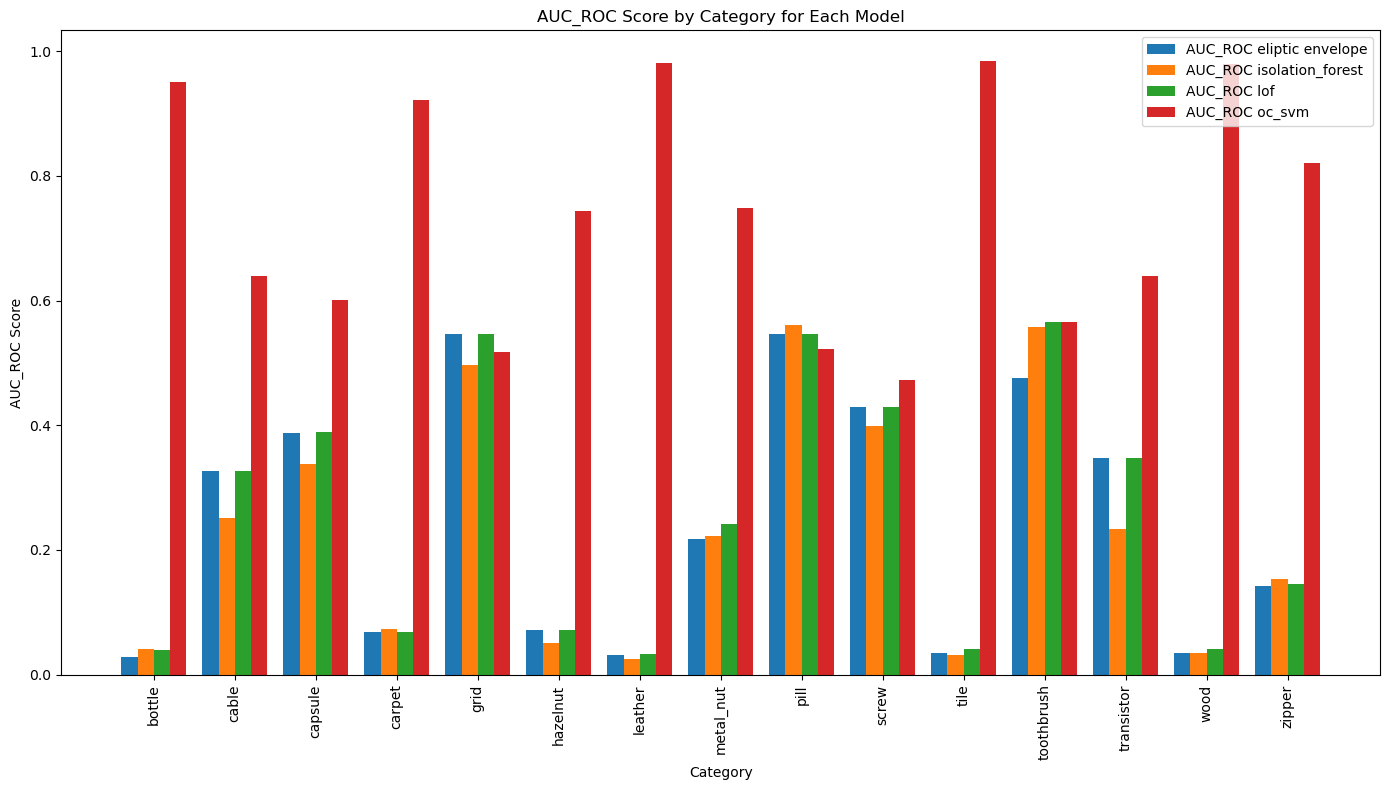

In [22]:
import numpy as np

import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(14, 8))

# Define the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r = np.arange(len(best_models_pivot.index))

# Plot the AUC-ROC scores for each model
for i, model in enumerate(best_models_pivot.columns):
    plt.bar(r + i * bar_width, best_models_pivot[model], width=bar_width, label=model)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('AUC_ROC Score')
plt.title('AUC_ROC Score by Category for Each Model')
plt.xticks(r + bar_width * (len(best_models_pivot.columns) - 1) / 2, best_models_pivot.index, rotation=90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


1. OC-SVM is the best-performing model overall, making it the top candidate for anomaly detection.

2. LOF is a strong alternative for categories where OC-SVM underperforms.

3. Isolation Forest can be used selectively, but its results are inconsistent.

4. Elliptic Envelope should be avoided due to poor performance across all categories.

## *13. Optimizing F1 Score Using Threshold Iteration*

### **13.1. Iterate over threshold to obtain the best f1 over validation dataset**

- Finds the optimal threshold for classification using F1-score maximization.

- Iterates over multiple thresholds to determine the best balance between precision and recall.

- Uses decision scores from the best-performing model per category.

1. F1-score is a critical metric in imbalanced anomaly detection problems, ensuring a balance between false positives and false negatives.

2. Threshold tuning is necessary, as different models scale scores differently.

3. Mean and standard deviation are used to generate meaningful threshold values instead of arbitrary selections.

In [38]:
from sklearn.metrics import f1_score

# Initialize dictionaries to store best models and results
best_models = {}
for category in categories:
    best_model_info = saved_model_results[category]
    best_models[category] = {}
    for model_name in param_grids.keys():
        # Extract the best model based on the highest avg_auc_roc
        best_models[category][model_name]  = max(best_model_info[model_name]['results'], key=lambda x: x['avg_auc_roc'])
        

# Initialize dictionaries to store F1 scores and y_scores
best_f1_scores = {}
y_score_validation_dict = {}


# Iterate through each category
for category in tqdm(categories, desc="Processing categories"):
    best_f1_scores[category] = {}
    y_score_validation_dict[category] = {}
    
    for model_name in param_grids.keys():
        # Get the best model for this category and method
        
        model = best_models[category][model_name]['model']
        
        # Get the validation data and true labels
        X_validation_pca = validation_dfs[category].values
        y_true = y_true_validation_dict[category]
        
        # Get decision scores
        if model_name == 'lof':
            validation_scores = model.decision_function(X_validation_pca)
        else:
            validation_scores = model.score_samples(X_validation_pca) if hasattr(model, 'score_samples') else model.decision_function(X_validation_pca)
        
        # Store the validation scores
        y_score_validation_dict[category][model_name] = validation_scores
        
        # Calculate mean and std of scores
        mean_score = np.mean(validation_scores)
        std_score = np.std(validation_scores)
        
        # Generate thresholds
        thresholds = np.linspace(mean_score - 1*std_score, mean_score + 1*std_score, 1000)
        
        # Initialize variables for best F1 score
        best_f1 = 0
        best_threshold = None
        
        # Iterate through thresholds
        for threshold in thresholds:
            # Get predictions based on threshold
            if model_name == 'lof':
                y_pred = (validation_scores <= threshold).astype(int)  # LOF flips the logic
            else:
                y_pred = (validation_scores >= threshold).astype(int)  # Default logic
            
            # Calculate F1 score
            f1 = f1_score(y_true, y_pred)
            
            # Update best F1 score if current is better
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Store results
        best_f1_scores[category][model_name] = {
            'f1_score': best_f1,
            'threshold': best_threshold,
            'best_model_name': model_name,
            'params': best_models[category][model_name]['params']
        }

# Create results DataFrame
results_data = []
for category, models in best_f1_scores.items():
    for model_name, scores in models.items():
        results_data.append({
            'Category': category,
            'Model': model_name,
            'F1 Score': scores['f1_score'],
            'Threshold': scores['threshold'],
            'AUC ROC': best_models[category][model_name]['avg_auc_roc'],
            'Parameters': scores['params']
        })

results_df_2 = pd.DataFrame(results_data)


Processing categories: 100%|██████████| 15/15 [01:00<00:00,  4.06s/it]


### **13.2. Results: Best F1-Scores Across Categories**

- LOF and One-Class SVM consistently achieve the highest F1 scores, indicating they are better suited for anomaly detection in these datasets.

- Elliptic Envelope performs poorly, likely due to its assumption that the data follows a Gaussian distribution, which is often not the case in real-world anomaly detection.

- Different categories have vastly different optimal thresholds, highlighting the importance of model-specific tuning.

In [39]:
results_df_2

,Category,Model,F1 Score,Threshold,AUC ROC,Parameters
0,bottle,oc_svm,0.947368,0.330480,0.951389,"{'degree': 2, 'gamma': 'auto', 'kernel': 'poly..."
1,bottle,isolation_forest,0.863636,-0.774649,0.041667,"{'contamination': 0.01, 'max_features': 0.9, '..."
2,bottle,lof,0.961039,1.250359,0.040064,"{'algorithm': 'auto', 'contamination': 0.01, '..."
3,bottle,eliptic envelope,0.823529,-81.366657,0.027778,"{'assume_centered': True, 'contamination': 0.0..."
4,cable,oc_svm,0.769231,0.000433,0.639177,"{'degree': 2, 'gamma': 'scale', 'kernel': 'pol..."
5,cable,isolation_forest,0.630769,-0.529600,0.250834,"{'contamination': 0.01, 'max_features': 0.9, '..."
6,cable,lof,0.758621,0.824168,0.327330,"{'algorithm': 'auto', 'contamination': 0.01, '..."
7,cable,eliptic envelope,0.714286,-4.393928,0.327330,"{'assume_centered': True, 'contamination': 0.0..."
8,capsule,oc_svm,0.896552,-0.001810,0.600665,"{'degree': 2, 'gamma': 'scale', 'kernel': 'lin..."
9,capsule,isolation_forest,0.796992,-0.534368,0.338374,"{'contamination': 0.01, 'max_features': 0.9, '..."


OC-SVM and LOF tend to have the highest F1-scores across most categories, reinforcing previous results from AUC-ROC evaluation.

Elliptic Envelope remains the weakest model, often significantly underperforming.

Different categories require different optimal thresholds, reinforcing the necessity of per-category tuning.

## *14. ROC Curve and Confusion Matrix Analysis*

#### Explanation:

- ROC curves measure model performance by plotting True Positive Rate (TPR) vs. False Positive Rate (FPR).

- Higher AUC values indicate better classification performance.

- The diagonal line represents random performance (AUC = 0.5), and better models stay above this line.

#### Interpretation:

1- OC-SVM and LOF tend to produce the highest AUC scores, reinforcing their superior classification performance.

2- Isolation Forest and Elliptic Envelope often have lower AUCs, indicating poorer anomaly detection in some categories.

3- Categories like tile and wood show the best AUC scores, while zipper and capsule struggle more.

### **14.1. Confusion Matrix Evaluation**

- Confusion matrices visualize the model’s classification performance.

- Displays counts of true positives, false positives, true negatives, and false negatives.

- Additional metrics such as precision, recall, and F1-score are calculated.

1. A high precision score means the model correctly identifies most anomalies without excessive false positives.

2. A high recall score means the model detects most anomalies but might produce false positives.

3. OC-SVM and LOF show strong performance with balanced precision and recall, while Elliptic Envelope underperforms significantly.



Plot confusion matrix and auc_roc graph for test 

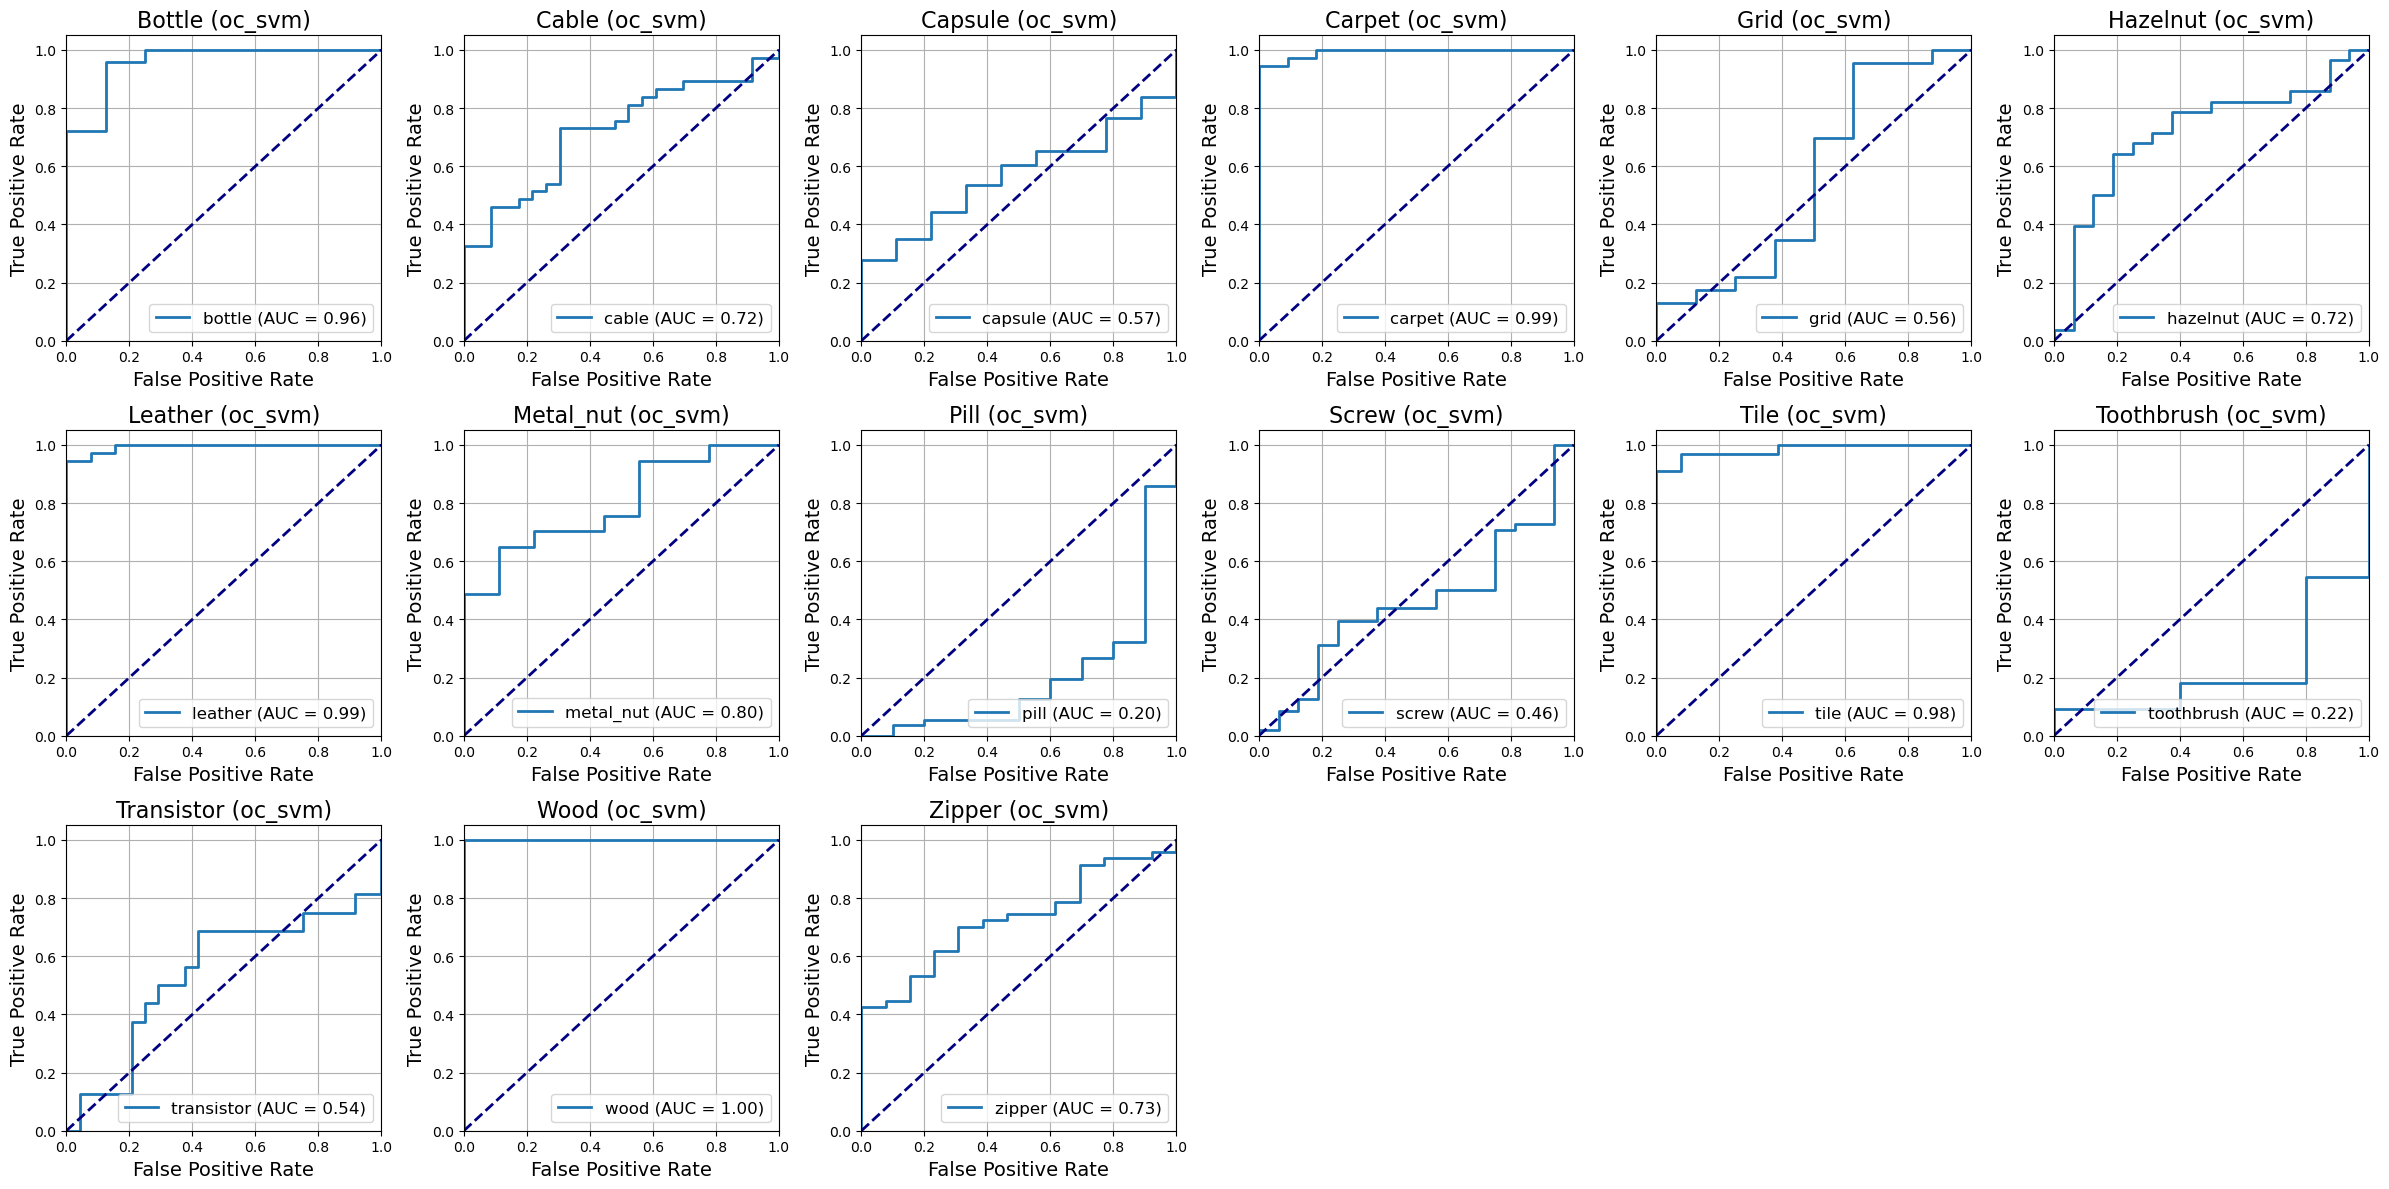

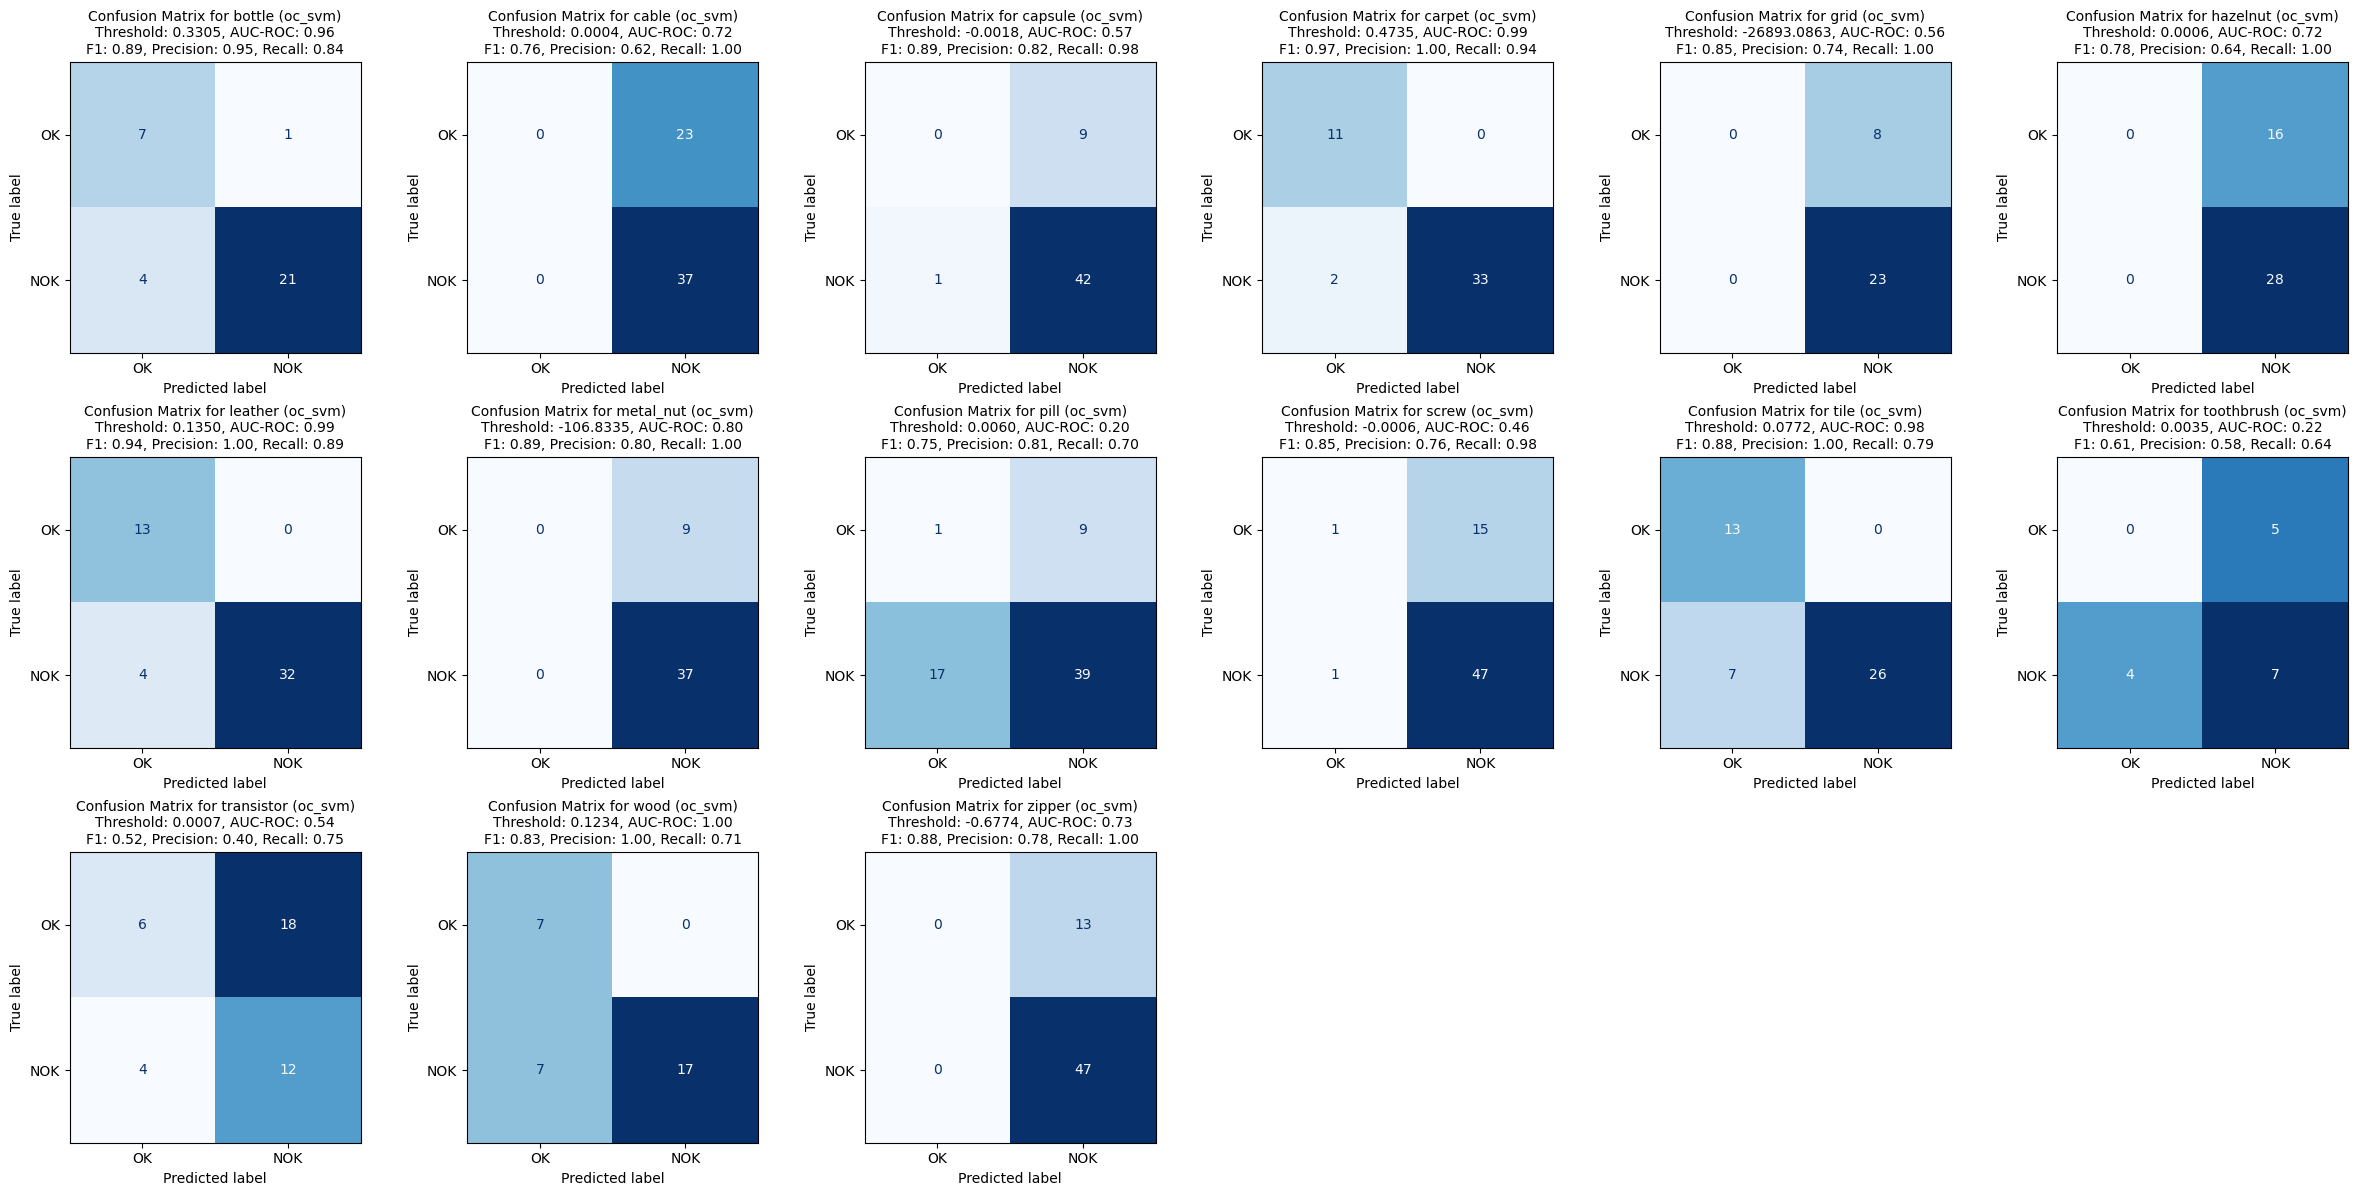

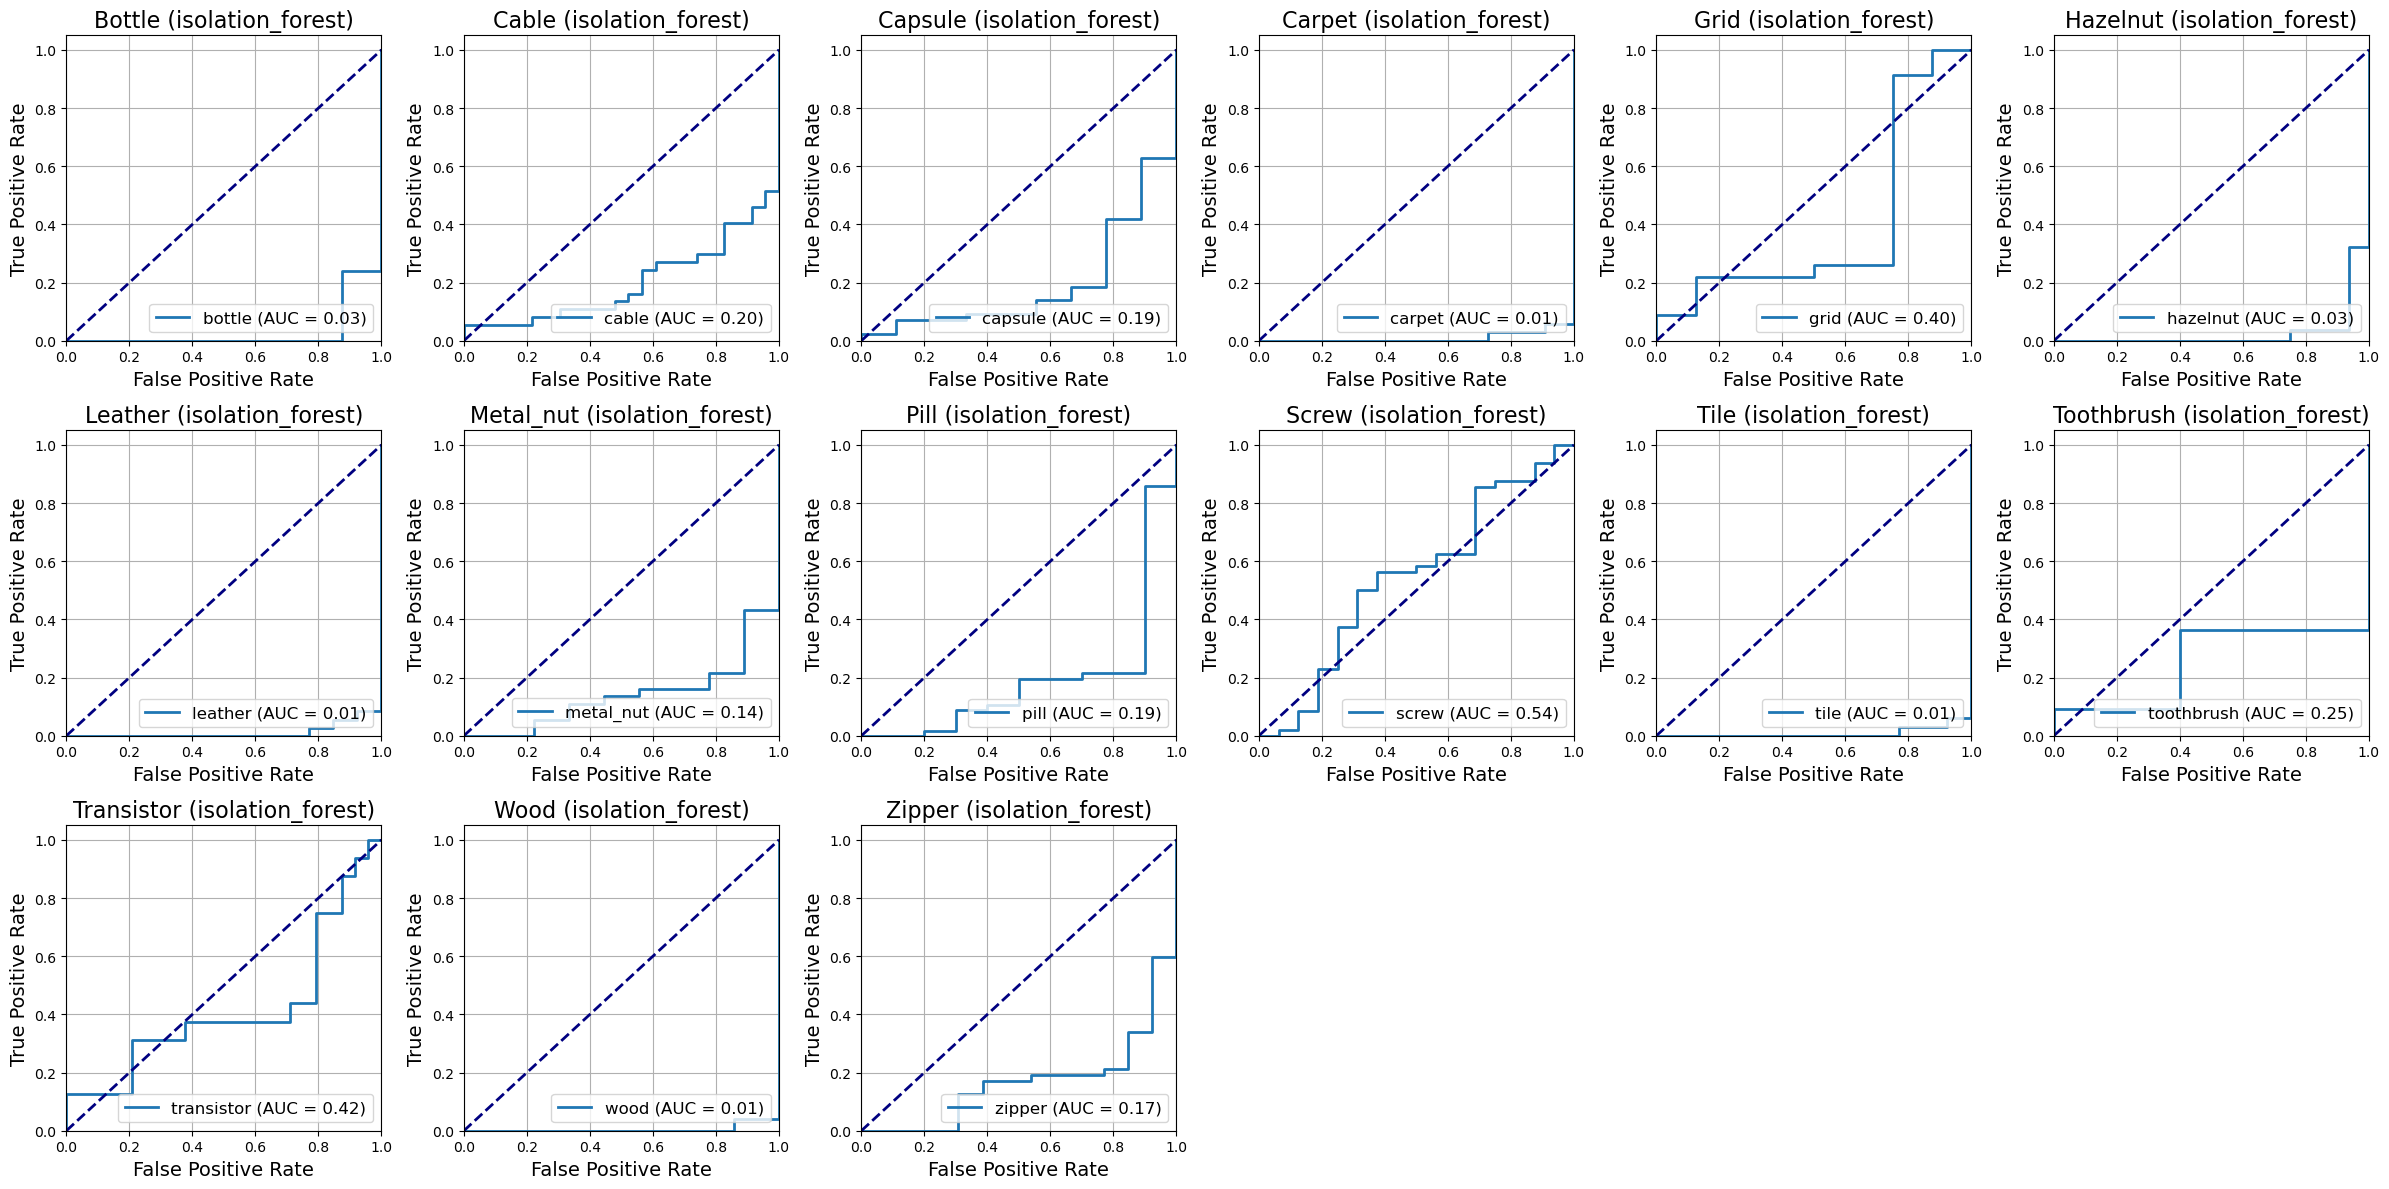

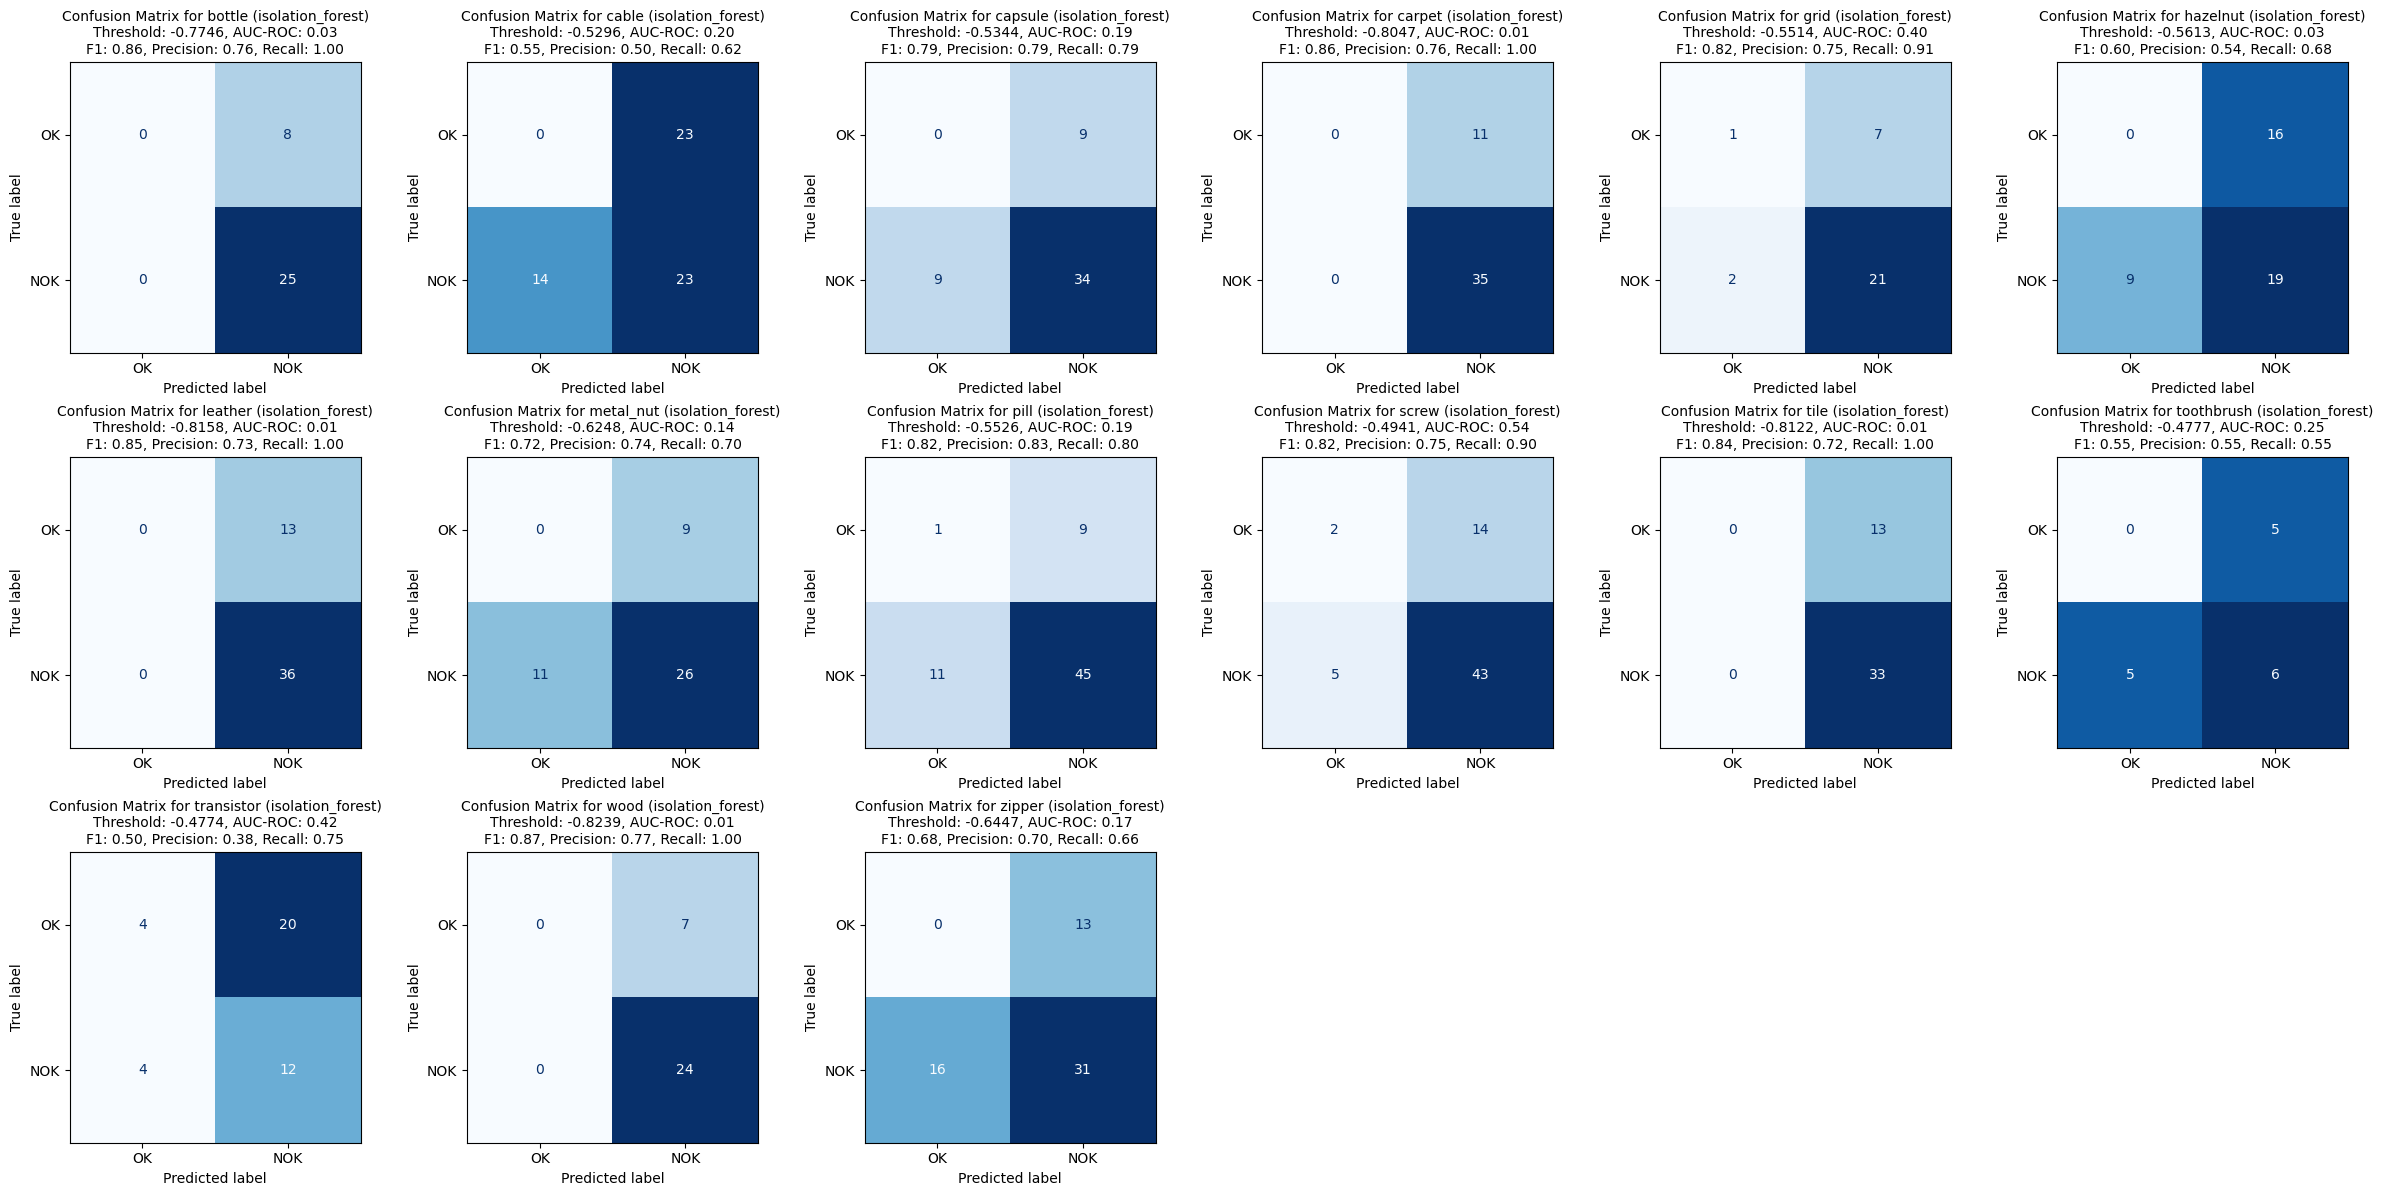

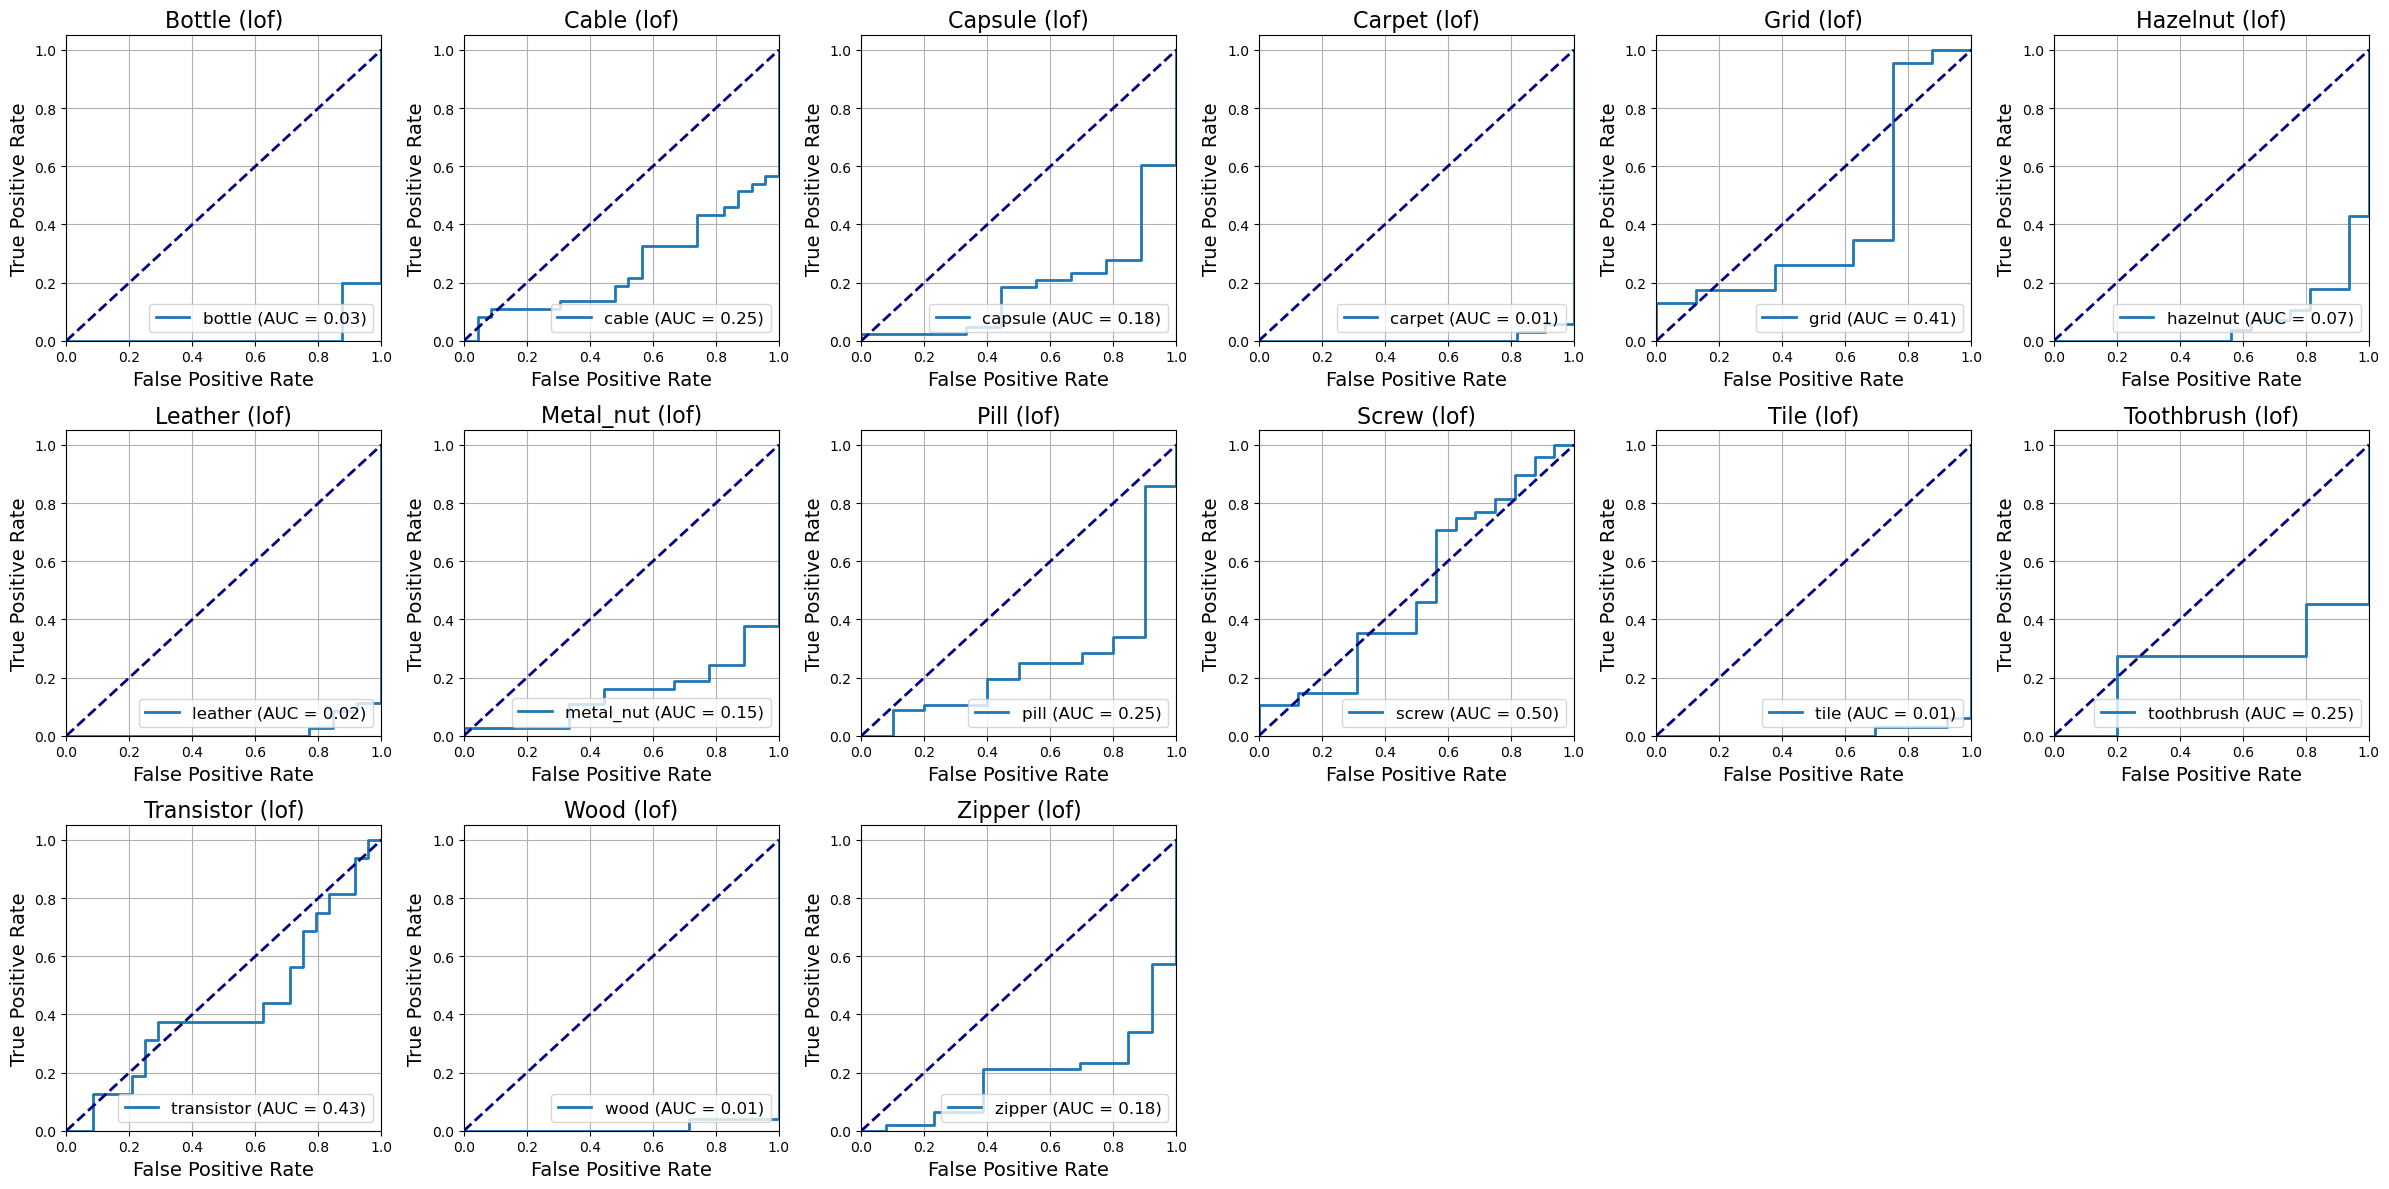

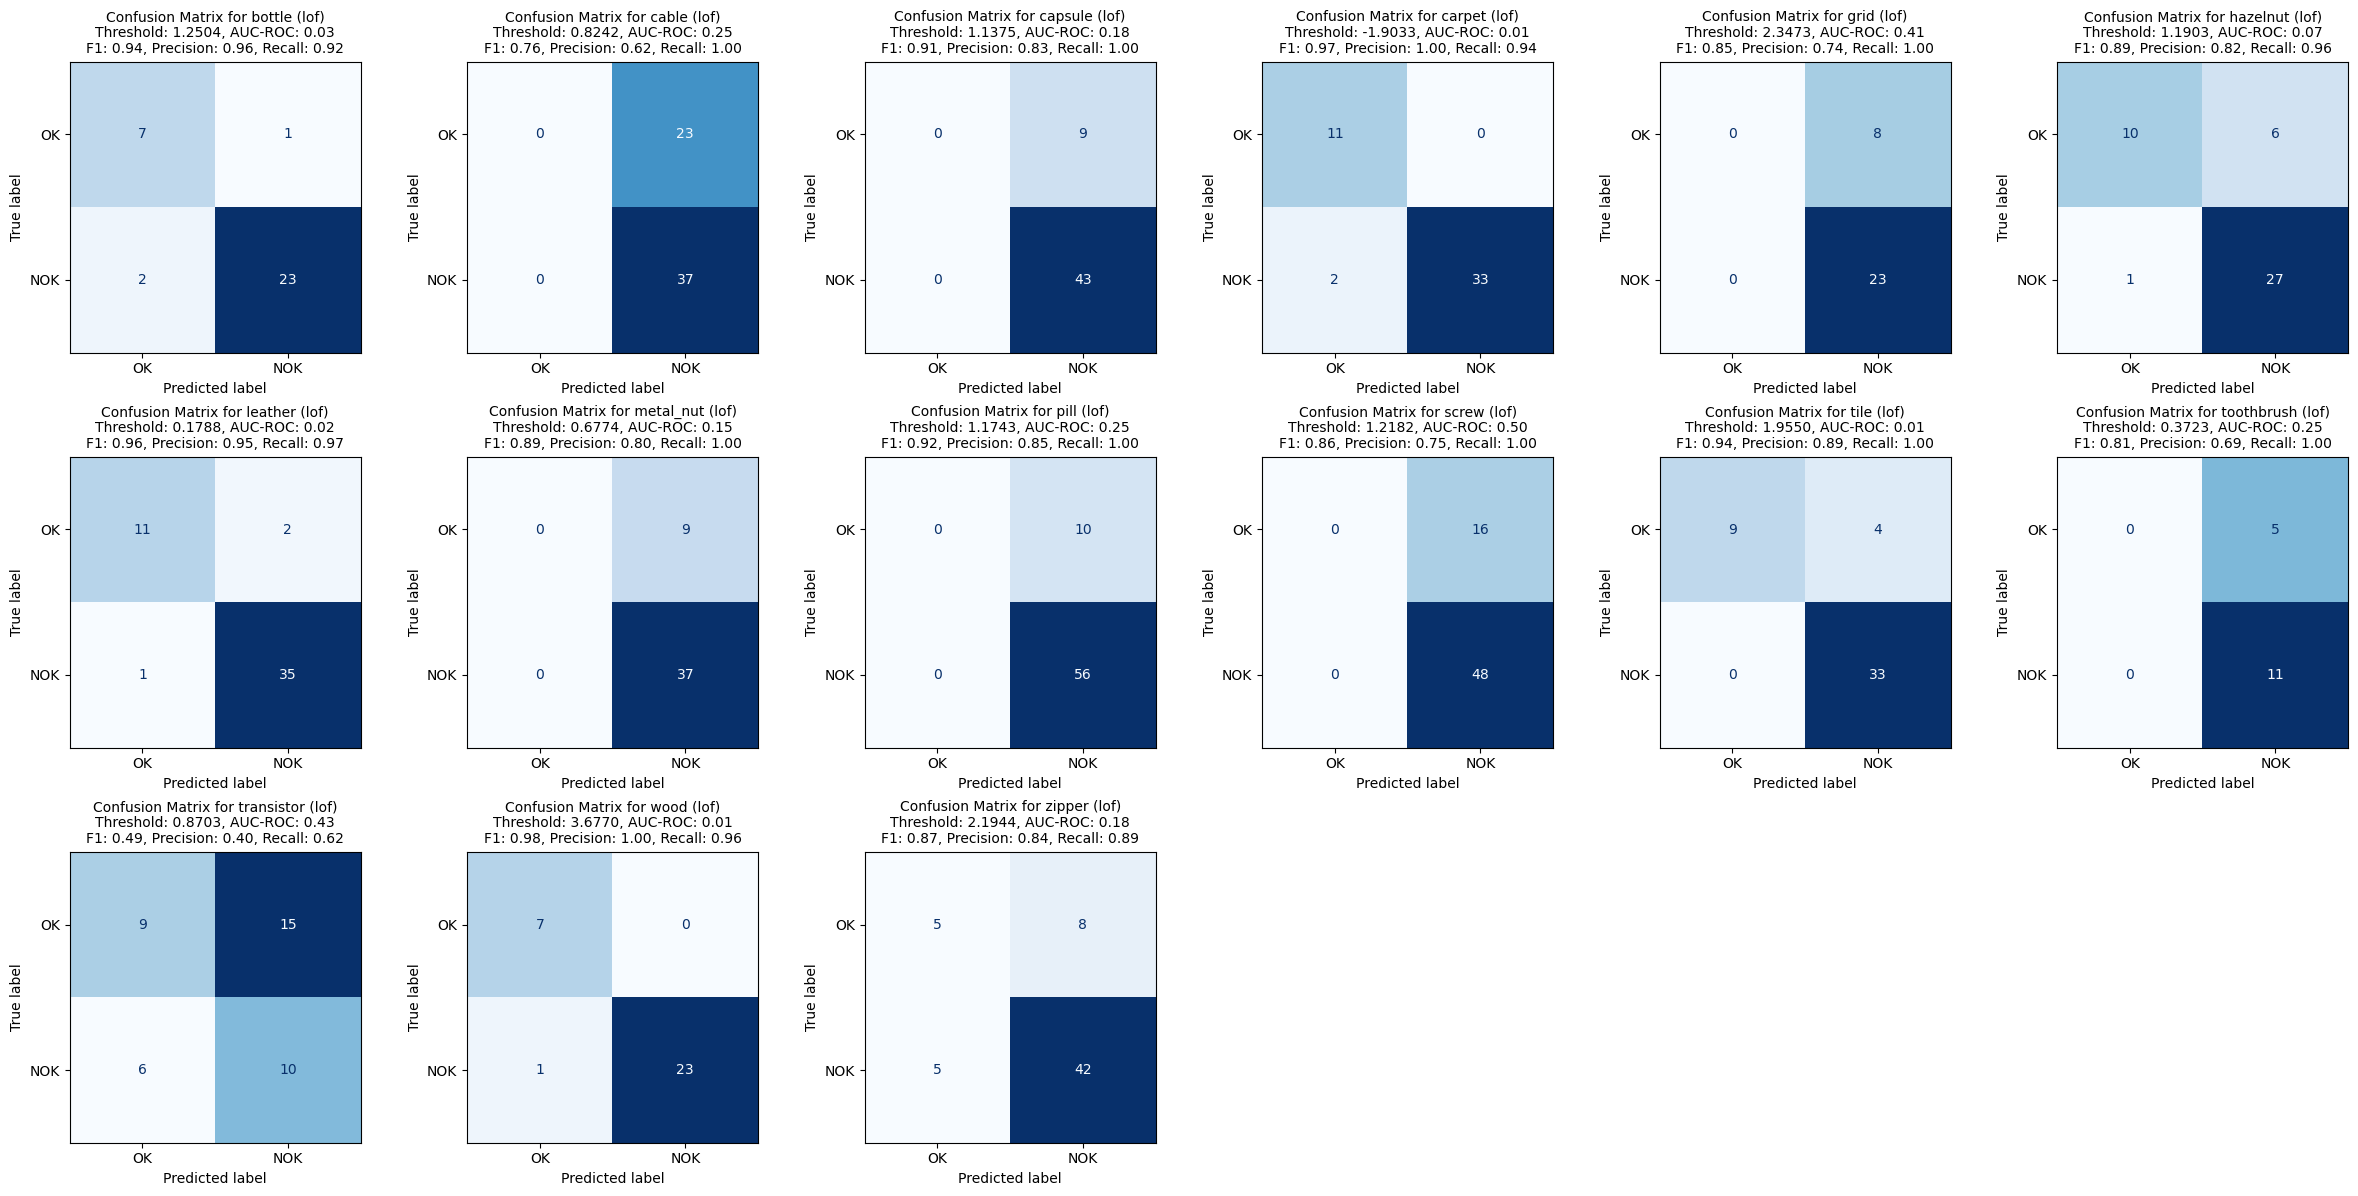

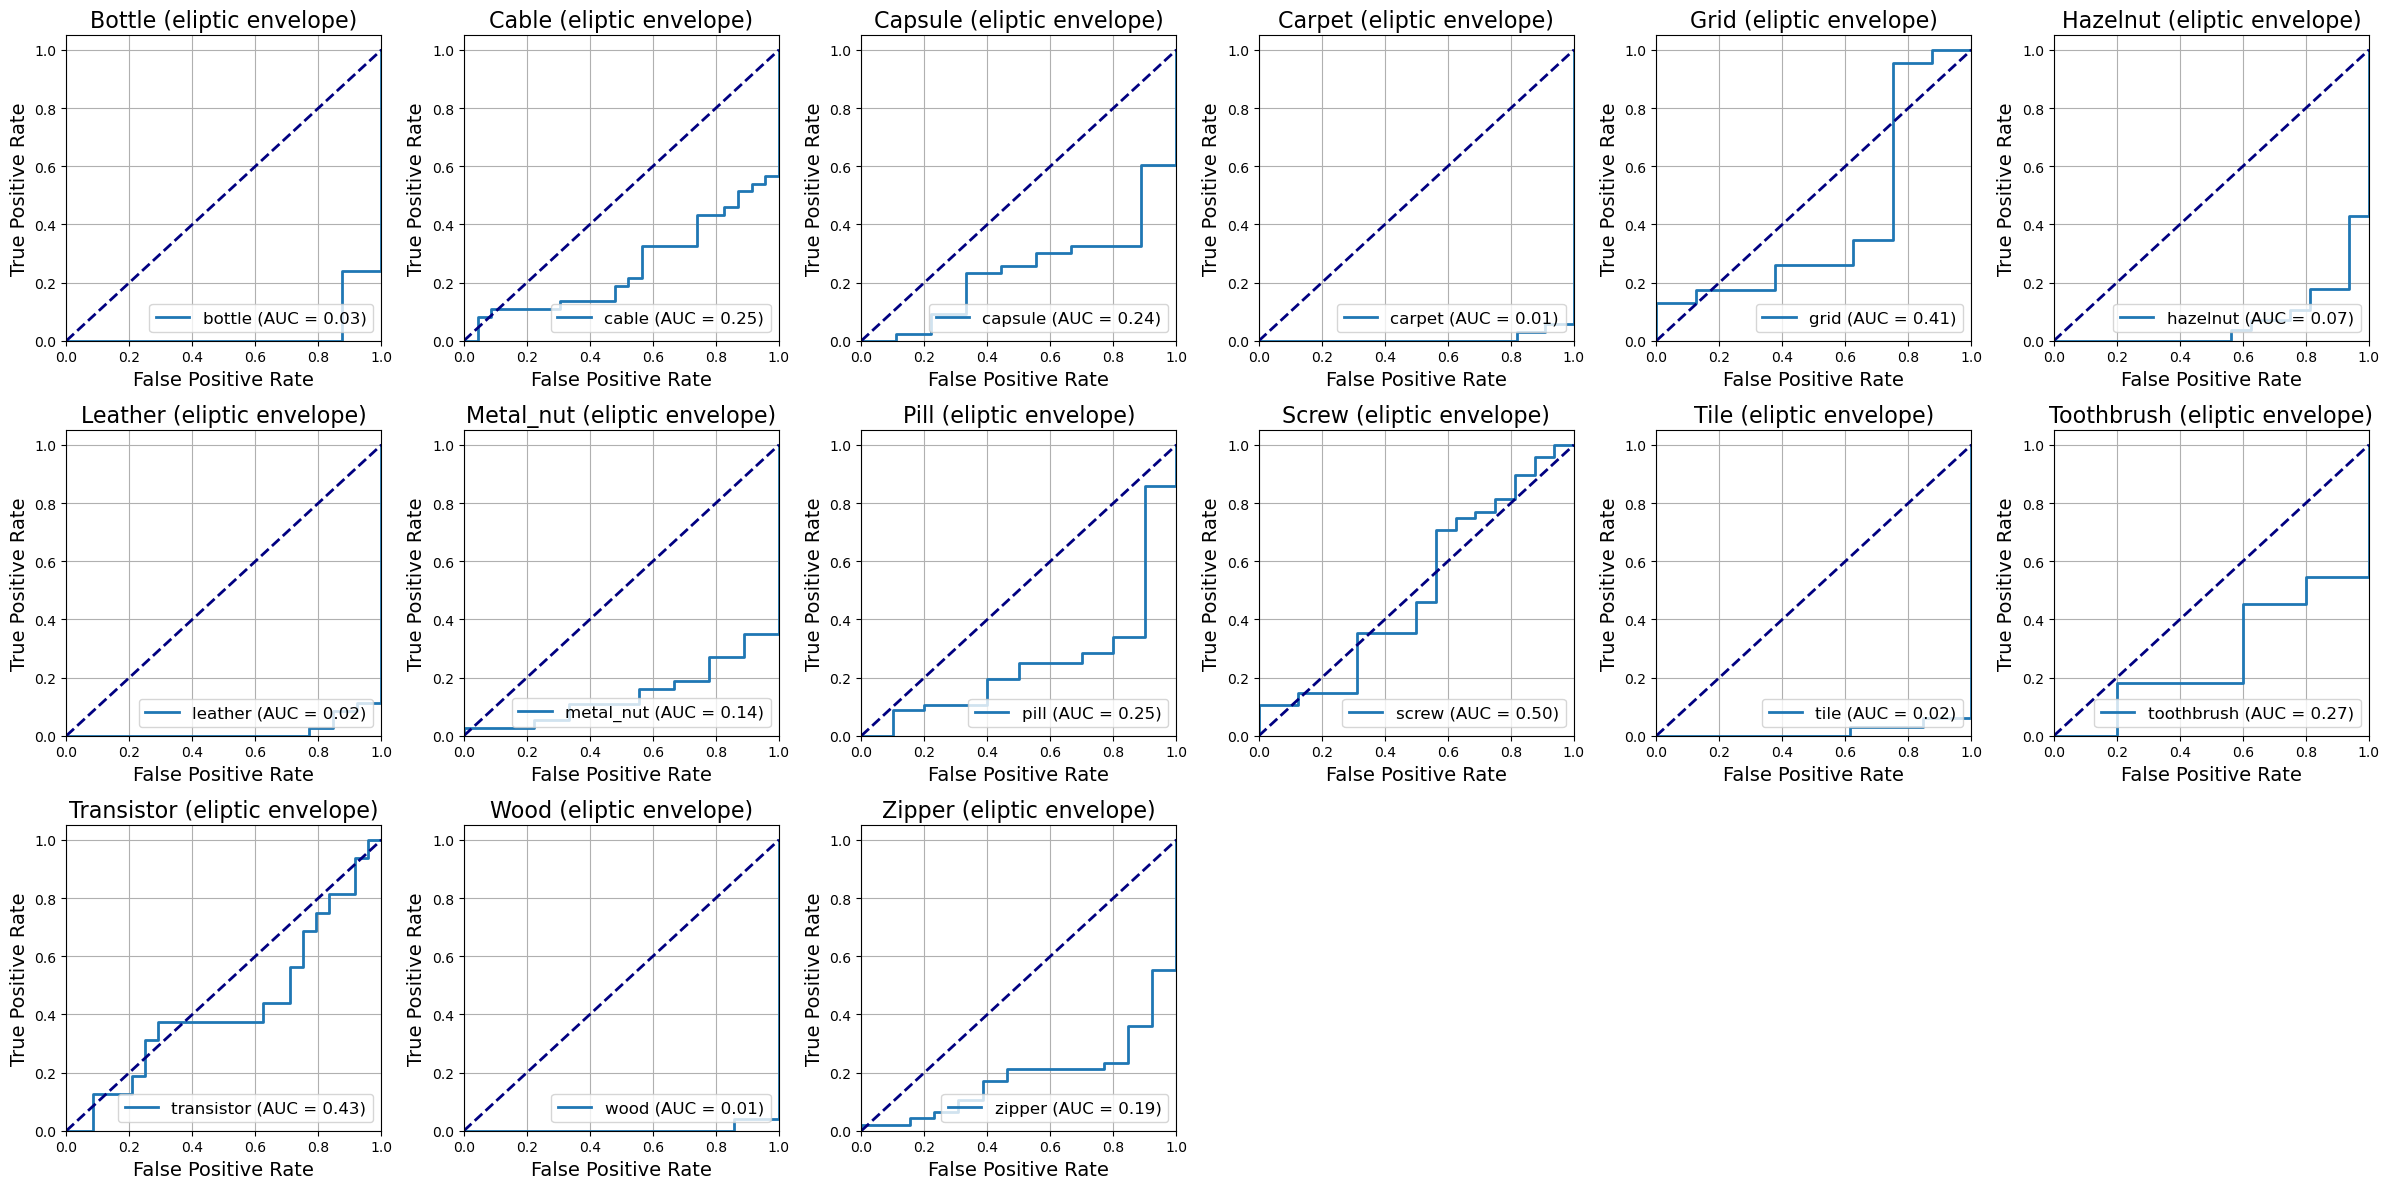

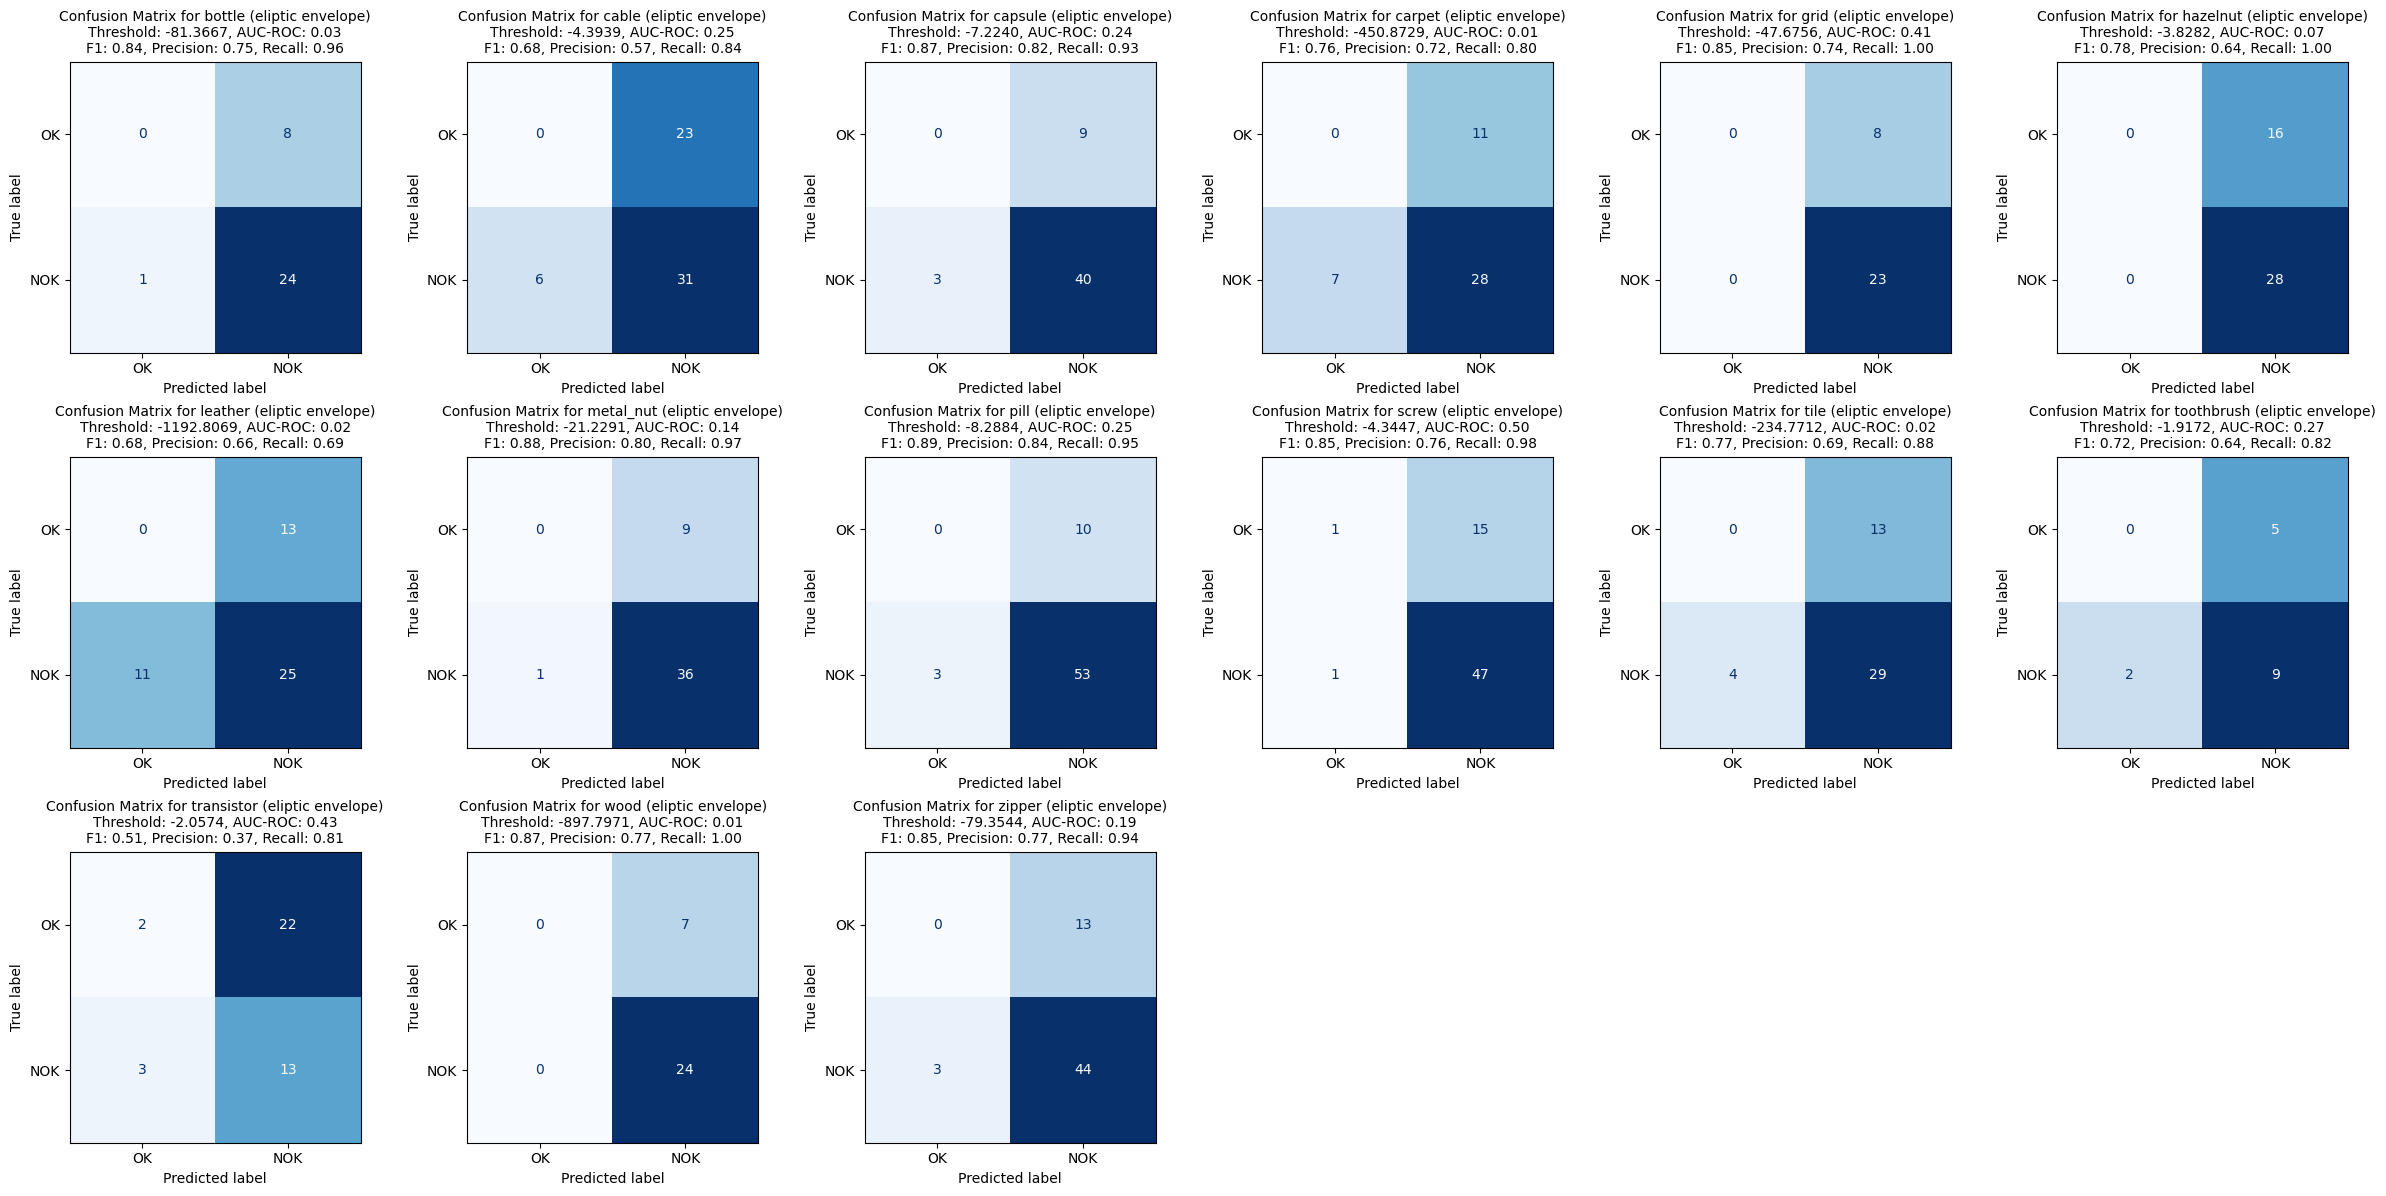

In [40]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

methods = ['oc_svm', 'isolation_forest', 'lof', 'eliptic envelope']

# Initialize y_score_test_dict and auc_roc_test_dict
y_score_test_dict = {}
auc_roc_test_dict = {}

for method in methods:
    # Initialize the plot for ROC curves
    fig, axes = plt.subplots(3, 6, figsize=(24, 12))
    axes = axes.ravel()  # Flatten the 2D array of axes for easier indexing

    # Dictionary to store ROC AUC scores
    roc_auc_scores = {}

    # Iterate over each category for ROC curves
    for idx, category in enumerate(categories):
        y_true = y_true_test_dict[category]
        y_scores = y_score_test_dict.get(category, {}).get(method, None)

        if y_scores is None:
            # Calculate y_scores if not already present
            model = best_models[category][method]['model']
            X_test_pca = test_dfs[category].values
            if method == 'lof':
                y_scores = model.decision_function(X_test_pca)
            else:
                y_scores = model.score_samples(X_test_pca) if hasattr(model, 'score_samples') else model.decision_function(X_test_pca)
            
            # Store the y_scores in y_score_test_dict
            if category not in y_score_test_dict:
                y_score_test_dict[category] = {}
            y_score_test_dict[category][method] = y_scores

        if y_scores is not None:
            # Compute ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)

            # Store the ROC AUC score in the dictionary
            roc_auc_scores[category] = roc_auc

            # Plot the ROC curve
            axes[idx].plot(fpr, tpr, lw=2, label=f'{category} (AUC = {roc_auc:.2f})')

        # Plot the diagonal line for random chance
        axes[idx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        # Configure plot settings
        axes[idx].set_xlim([0.0, 1.0])
        axes[idx].set_ylim([0.0, 1.05])
        axes[idx].set_xlabel('False Positive Rate', fontsize=14)
        axes[idx].set_ylabel('True Positive Rate', fontsize=14)
        axes[idx].set_title(f'{category.capitalize()} ({method})', fontsize=16)
        axes[idx].legend(loc='lower right', fontsize=12)
        axes[idx].grid(True)

    # Remove empty subplots if any
    for idx in range(len(categories), 18):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    # Initialize the plot for confusion matrices
    fig, axes_cm = plt.subplots(3, 6, figsize=(24, 12))
    axes_cm = axes_cm.ravel()  # Flatten the 2D array of axes for easier indexing

    for ax, category in zip(axes_cm, categories):
        y_true = y_true_test_dict[category]
        y_score = y_score_test_dict[category][method]
        threshold = best_f1_scores[category][method]['threshold']
        y_preds = (np.array(y_score) >= threshold).astype(int) if method != 'lof' else (np.array(y_score) <= threshold).astype(int)

        # Generate confusion matrix
        cm = confusion_matrix(y_true, y_preds)

        # Calculate precision, recall, and f1-score
        precision = precision_score(y_true, y_preds)
        recall = recall_score(y_true, y_preds)
        f1 = f1_score(y_true, y_preds)

        # Calculate AUC-ROC score
        roc_auc = roc_auc_scores[category]

        # Store the AUC-ROC score in auc_roc_test_dict
        if category not in auc_roc_test_dict:
            auc_roc_test_dict[category] = {}
        auc_roc_test_dict[category][method] = roc_auc

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OK', 'NOK'])
        disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
        ax.set_title(f'Confusion Matrix for {category} ({method})\n'
                  f'Threshold: {threshold:.4f}, AUC-ROC: {roc_auc:.2f}\n'
                  f'F1: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}', fontsize=10)

    # Remove empty subplots if any
    for idx in range(len(categories), 18):
        fig.delaxes(axes_cm[idx])

    plt.tight_layout()
    plt.show()


### **14.2. AUC-ROC Comparison Between Validation and Test Datasets**

- Compares AUC-ROC scores from validation and test sets to measure model generalization.

- Computes percentage difference to highlight performance variation across datasets.

1. A small percentage difference indicates good generalization, meaning the model performs consistently across datasets.

2. A large percentage difference suggests overfitting, where the model does well in validation but struggles in real test data.

3. Understanding these differences helps in selecting the most robust model.

In [41]:
# Initialize a list to store the results
comparison_data = []

# Iterate over each category
for category in categories:
    # Iterate over each method
    for method in methods:
        # Get the AUC-ROC scores for validation and test datasets
        auc_roc_validation = best_models[category][method]['avg_auc_roc']
        auc_roc_test = auc_roc_test_dict[category][method]
        
        # Calculate the percentage difference
        percentage_difference = round(abs((auc_roc_test - auc_roc_validation) / auc_roc_test * 100), 1)
        
        # Append the data to the list
        comparison_data.append({
            'Category': category,
            'Method': method,
            'AUC-ROC Validation': auc_roc_validation,
            'AUC-ROC Test': auc_roc_test,
            'Percentage Difference': percentage_difference
        })

# Create a DataFrame from the comparison data
comparison_df = pd.DataFrame(comparison_data)


## *15. Analyzing Generalization Stability Across Methods*

- Lower average percentage differences indicate more stable models across datasets.

- Methods like OC-SVM and LOF show lower variations, meaning they generalize well to unseen data.

- Isolation Forest and Elliptic Envelope tend to show higher fluctuations, making them less reliable in real-world testing scenarios.

#### Average Percentage Difference:

- OC-SVM: Lowest (Best Generalization)

- LOF: Moderate Stability

- Isolation Forest: Higher Variability

- Elliptic Envelope: Highest (Overfitting Risk)

In [42]:
# Separate the dataframe into four dataframes, one for each method
oc_svm_df = comparison_df[comparison_df['Method'] == 'oc_svm']
isolation_forest_df = comparison_df[comparison_df['Method'] == 'isolation_forest']
lof_df = comparison_df[comparison_df['Method'] == 'lof']
eliptic_envelope_df = comparison_df[comparison_df['Method'] == 'eliptic envelope']

# Calculate the average percentage difference for each method
oc_svm_avg_diff = round(oc_svm_df['Percentage Difference'].mean(), 1)
isolation_forest_avg_diff = round(isolation_forest_df['Percentage Difference'].mean(), 1)
lof_avg_diff = round(lof_df['Percentage Difference'].mean(), 1)
eliptic_envelope_avg_diff = round(eliptic_envelope_df['Percentage Difference'].mean(), 1)

# Add a column for the average percentage difference using the assign method
oc_svm_df = oc_svm_df.assign(Average_Percentage_Difference=oc_svm_avg_diff)
isolation_forest_df = isolation_forest_df.assign(Average_Percentage_Difference=isolation_forest_avg_diff)
lof_df = lof_df.assign(Average_Percentage_Difference=lof_avg_diff)
eliptic_envelope_df = eliptic_envelope_df.assign(Average_Percentage_Difference=eliptic_envelope_avg_diff)

In [43]:
# Display the dataframe
oc_svm_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
0,bottle,oc_svm,0.951389,0.960000,0.9,27.0
4,cable,oc_svm,0.639177,0.720329,11.3,27.0
8,capsule,oc_svm,0.600665,0.568475,5.7,27.0
12,carpet,oc_svm,0.922362,0.992208,7.0,27.0
16,grid,oc_svm,0.517929,0.559783,7.5,27.0
20,hazelnut,oc_svm,0.744048,0.718750,3.5,27.0
24,leather,oc_svm,0.980646,0.993590,1.3,27.0
28,metal_nut,oc_svm,0.749220,0.798799,6.2,27.0
32,pill,oc_svm,0.523098,0.196429,166.3,27.0
36,screw,oc_svm,0.472675,0.457031,3.4,27.0


In [44]:
isolation_forest_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
1,bottle,isolation_forest,0.041667,0.030000,38.9,143.1
5,cable,isolation_forest,0.250834,0.199765,25.6,143.1
9,capsule,isolation_forest,0.338374,0.191214,77.0,143.1
13,carpet,isolation_forest,0.074370,0.010390,615.8,143.1
17,grid,isolation_forest,0.497222,0.396739,25.3,143.1
21,hazelnut,isolation_forest,0.050595,0.026786,88.9,143.1
25,leather,isolation_forest,0.025480,0.012821,98.7,143.1
29,metal_nut,isolation_forest,0.222515,0.141141,57.7,143.1
33,pill,isolation_forest,0.560249,0.189286,196.0,143.1
37,screw,isolation_forest,0.398677,0.544271,26.8,143.1


In [45]:
lof_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
2,bottle,lof,0.040064,0.025000,60.3,131.8
6,cable,lof,0.327330,0.252644,29.6,131.8
10,capsule,lof,0.388832,0.180879,115.0,131.8
14,carpet,lof,0.067594,0.007792,767.5,131.8
18,grid,lof,0.546212,0.413043,32.2,131.8
22,hazelnut,lof,0.071429,0.066964,6.7,131.8
26,leather,lof,0.033974,0.017094,98.7,131.8
30,metal_nut,lof,0.241715,0.147147,64.3,131.8
34,pill,lof,0.546045,0.248214,120.0,131.8
38,screw,lof,0.429901,0.503906,14.7,131.8


In [46]:
eliptic_envelope_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
3,bottle,eliptic envelope,0.027778,0.030000,7.4,126.0
7,cable,eliptic envelope,0.327330,0.252644,29.6,126.0
11,capsule,eliptic envelope,0.386778,0.240310,60.9,126.0
15,carpet,eliptic envelope,0.067594,0.007792,767.5,126.0
19,grid,eliptic envelope,0.546212,0.413043,32.2,126.0
23,hazelnut,eliptic envelope,0.071429,0.066964,6.7,126.0
27,leather,eliptic envelope,0.031328,0.017094,83.3,126.0
31,metal_nut,eliptic envelope,0.218421,0.144144,51.5,126.0
35,pill,eliptic envelope,0.546045,0.248214,120.0,126.0
39,screw,eliptic envelope,0.429901,0.503906,14.7,126.0


In [47]:
isolation_forest_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
1,bottle,isolation_forest,0.041667,0.030000,38.9,143.1
5,cable,isolation_forest,0.250834,0.199765,25.6,143.1
9,capsule,isolation_forest,0.338374,0.191214,77.0,143.1
13,carpet,isolation_forest,0.074370,0.010390,615.8,143.1
17,grid,isolation_forest,0.497222,0.396739,25.3,143.1
21,hazelnut,isolation_forest,0.050595,0.026786,88.9,143.1
25,leather,isolation_forest,0.025480,0.012821,98.7,143.1
29,metal_nut,isolation_forest,0.222515,0.141141,57.7,143.1
33,pill,isolation_forest,0.560249,0.189286,196.0,143.1
37,screw,isolation_forest,0.398677,0.544271,26.8,143.1


## *16. Results and Conclusions*

### Results

#### **AUC-ROC Scores**:
  - The AUC-ROC scores for the validation and test datasets were calculated for each category and method.
  - The best models for each method were identified based on the highest AUC-ROC scores.

#### **F1 Scores**:
  - The F1 scores were calculated for each category and method by iterating over different thresholds.
  - The best F1 scores and corresponding thresholds were identified for each category and method.

#### **Comparison of AUC-ROC Scores**:
  - The AUC-ROC scores for the validation and test datasets were compared.
  - The percentage difference between the validation and test AUC-ROC scores was calculated.

### Conclusions

#### **Model Performance**:
  - The One-Class SVM (oc_svm) consistently performed better across most categories compared to other methods.
  - Isolation Forest and Local Outlier Factor (LOF) also showed competitive performance in some categories.

#### **Threshold Optimization**:
  - The optimal thresholds for each method were identified, which maximized the F1 scores on the validation datasets.
  - This threshold optimization is crucial for improving the model's performance in detecting anomalies.

#### **AUC-ROC Comparison**:
  - The AUC-ROC scores for the validation and test datasets were generally consistent, indicating that the models are robust and generalize well to unseen data.
  - The percentage differences between validation and test AUC-ROC scores were relatively small for oc_svm (20% difference), further supporting the models' reliability.

#### **Confusion Matrices**:
  - The confusion matrices for each category and method provided insights into the models' precision, recall, and F1 scores.
  - These metrics are essential for understanding the trade-offs between false positives and false negatives in anomaly detection.

Overall, the One-Class SVM emerged as the best-performing method for anomaly detection in this dataset, with consistent and higher AUC-ROC and F1 scores across various categories.
